# Observable 1

En este notebook se describen los análisis realizados sobre los espacios de parametros derivados del observable 1.


* esp 1: $\rho^{450}_{\mu}$ y $\sqrt{S_{rad}}$


* esp 2: $\dfrac{\rho^{450}_{\mu}}{\sqrt{S_{rad}}}$ y E$_{true}$


* esp 3: $\rho^{450}_{\mu}$, $\sqrt{S_{rad}}$ y E$_{true}$


* esp 4: $\rho^{450}_{\mu}$, $\sqrt{S_{rad}}$, E$_{true}$ y $\theta$


* esp 5: $\rho^{450}_{\mu}$, $\sqrt{S_{rad}}$, E$_{true}$, $\theta$ y estaciones de radio.

In [1]:
#Librerias importantes
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, balanced_accuracy_score,precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
import os

In [2]:
def MeritFactor(v1, v2):
    #Calculo de MF
    muF, stdF = norm.fit(v1)
    muP, stdP = norm.fit(v2)
    #muF, stdF = np.mean(v1), np.std(v1)
    #muP, stdP = np.mean(v2), np.std(v2)
    MF = np.abs(muF - muP) / (np.sqrt(pow(stdF,2) + pow(stdP,2)))
    return MF

In [3]:
def boostMF(v1, v2):
    vv=[]
    size=int(len(v1))
    for i in range(20000):
        #np.random.seed(seed=None)
        samplexF = np.random.choice(v1, size=int(size*0.90), replace=True)
        samplexP = np.random.choice(v2, size=int(size*0.90), replace=True)
        MF = MeritFactor(np.array(samplexP), np.array(samplexF))
        vv.append(np.abs(MF))
    
    avg, std = norm.fit(vv)
    return "%.2f"%avg, "%.2f"%std

In [4]:
# To plot pretty figures
import matplotlib as mpl
mpl.rc('axes', labelsize=22)
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)

# Where to save the figures
PROJECT_ROOT_DIR = "/home/csarmiento/MEGA/phd_mega/analisisDeDatos/ML_MassComp/"
#CHAPTER_ID = "05_ModelosLineales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, figsize=(10,8))

In [5]:
#Función para calcular el accuracy
def accuracy(X, y, model):
    a=accuracy_score(y, model.predict(X))
    return a

In [6]:
#Función para calcular el accuracy via Cross-Val score
#Esto nos sirve para validar nuestro modelo sin usar los datos de test
def crossAccuracy(X, y, model):
    scoresGauTrain= cross_val_score(model, X, y, cv=10, scoring="accuracy");
    pres = cross_val_score(model, X, y, cv=10, scoring="precision");
    recl = cross_val_score(model, X, y, cv=10, scoring="recall");
    F1 = 2/((1/pres)+(1/recl))
    print("Accuracy: ", scoresGauTrain.mean(), scoresGauTrain.std())
    print("presicion: ", pres.mean(), pres.std())
    print("recall: ", recl.mean(), recl.std())
    print("F1_score: ", F1.mean(), F1.std())

In [7]:
"""
Matriz de Confusion
Con MC podemos ver en detalle el comportamiento del modelo y saber cuantos eventos fueron mal clasificados.
Esta podría ser una mirada más realista que el accuracy.

>>> La precisión es definida como el ratio entre verdaderos positivos y número total 
de positivos predichos. Esto nos dice la fracción de los eventos que el modelo nos 
dice que son de la clase, realmente lo son.

>>> El recall o exhaustividad es definida como el es el ratio entre los verdaderos positivos 
y la suma de los verdaderos positivos y los falsos negativos. Esto nos dice la fracción
de los elementos de la clase encontró.
"""
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
def mconfusion(X, y, model):
    aux_pred = cross_val_predict(model, X, y, cv=10)
    cm = confusion_matrix(y, aux_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pres=tp/(tp + fp)
    exha=tp/(tp + fn)
    print("Matriz de confusión, \n"), print(cm), print("precisión: ", pres), print("exhaustividad: ", exha)

In [8]:
#Funcion para calcular la energia con GeoCeLDF
def GeoCeEnergy(RadEnergy, Alpha):
    d = 2.3137 * 1e14   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    c = 0.505
    E = d * pow(RadEnergy / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c)
    #return list(E)
    return np.array(E)
 
def GeoCeEnergyError(RadEnergy, RadEnergyError, Alpha):
    c = 0.505   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    errorE = pow(1 / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c) * pow(RadEnergy, c - 1) * RadEnergyError
    return errorE

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

def auc_cv(X, y, model):
    model = model
    X = np.array(X)
    y = np.array(y)
    random_state = np.random.RandomState(369)

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)

    tprs = []
    for i, (train, train) in enumerate(cv.split(X, y)):
        viz = roc_auc_score(y[train], model.predict_proba(X[train])[:, 1])
        tprs.append(viz)

    print(np.mean(tprs), np.std(tprs))

In [10]:
#A partir de aquí python sabe en que carpeta se encuentran los datos
os.chdir("/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData/")
os.getcwd()

'/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData'

In [11]:
#Cargando datos
df= pd.read_csv(r"CutEvents_IronRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")
dp= pd.read_csv(r"CutEvents_ProtonRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")

In [16]:
print(df.shape, dp.shape)

(305, 59) (305, 59)


In [17]:
#angulo alfa
AlphaFe=df['lorentz angle']
AlphaFe=np.array(AlphaFe)
AlphaPr=dp['lorentz angle']
AlphaPr=np.array(AlphaPr)

#radiation energy
RadEGeoCeFe=df['GeoCe Erad']
RadEGeoCeFe=np.array(RadEGeoCeFe)
RadEGeoCePr=dp['GeoCe Erad']
RadEGeoCePr=np.array(RadEGeoCePr)

#radiation energy error
RadEGeoCeFe_err=df['GeoCe Erad Error']
RadEGeoCeFe_err=np.array(RadEGeoCeFe_err)
RadEGeoCePr_err=dp['GeoCe Erad Error']
RadEGeoCePr_err=np.array(RadEGeoCePr_err)

#Energia Rd
GeoCeEnergyFe=GeoCeEnergy(RadEGeoCeFe,AlphaFe)
GeoCeEnergyFe_err=GeoCeEnergyError(RadEGeoCeFe, RadEGeoCeFe_err, AlphaFe)
GeoCeEnergyPr=GeoCeEnergy(RadEGeoCePr,AlphaPr)
GeoCeEnergyPr_err=GeoCeEnergyError(RadEGeoCePr,RadEGeoCePr_err, AlphaPr)

df["EnergyRd"] = GeoCeEnergyFe
dp["EnergyRd"] = GeoCeEnergyPr

In [18]:
df.head()

,runnr,MC energy,MC zenith,MC azimuth,MC Xmax,MC core x,MC core y,MC core z,Sd rec success,Sd energy,...,N_mu_ref,N_mu_ref error,MLDF Chi2,MLDF NDF,MLDF Likelihood,M beta,M beta error,M beta syst,pvalueMd,EnergyRd
0,100010,7.992670e+17,47.9999,20.3020,660.695,448781,6114250.0,1478.29,1,6.018360e+17,...,1.531090,0.111074,21.6080,24,13.32660,0.947208,0.265867,0,0.602650,6.084846e+17
1,100065,8.181170e+17,49.0520,227.2380,633.066,449942,6114630.0,1470.26,1,6.295360e+17,...,1.681410,0.113030,34.9362,32,16.69380,0.964438,0.210569,0,0.330259,5.899122e+17
2,100068,5.268060e+17,48.4671,335.0870,607.021,450708,6115470.0,1466.80,1,4.327620e+17,...,0.904964,0.093389,13.7102,17,8.17662,0.679882,0.397132,0,0.687502,3.641190e+17
3,100118,9.110670e+17,41.4961,3.9628,646.300,449366,6113960.0,1472.36,1,8.310780e+17,...,1.663720,0.112681,38.0164,29,20.59740,0.970677,0.116420,0,0.121971,6.537687e+17
4,100141,3.790780e+17,44.6878,264.8550,621.315,449778,6114410.0,1472.18,1,3.332330e+17,...,0.647642,0.069420,30.8319,26,23.16070,0.743484,0.341727,0,0.234591,2.717266e+17


In [19]:
dp.head()

,runnr,MC energy,MC zenith,MC azimuth,MC Xmax,MC core x,MC core y,MC core z,Sd rec success,Sd energy,...,N_mu_ref,N_mu_ref error,MLDF Chi2,MLDF NDF,MLDF Likelihood,M beta,M beta error,M beta syst,pvalueMd,EnergyRd
0,100010,7.992670e+17,47.9999,20.3020,681.155,448781,6114250.0,1478.29,1,5.226880e+17,...,1.012100,0.093378,20.6266,21,13.9757,1.071470e+00,0.369204,0,0.481940,6.653652e+17
1,100065,8.181170e+17,49.0520,227.2380,786.129,449942,6114630.0,1470.26,1,8.397900e+17,...,1.322240,0.097802,32.0101,36,19.8798,1.525850e+00,0.223773,0,0.658872,5.918165e+17
2,100068,5.268060e+17,48.4671,335.0870,687.084,450708,6115470.0,1466.80,1,3.366820e+17,...,0.753167,0.081812,22.4833,20,15.3582,8.919260e-01,0.316713,0,0.314870,3.971764e+17
3,100118,9.110670e+17,41.4961,3.9628,707.196,449366,6113960.0,1472.36,1,7.256900e+17,...,1.222870,0.092920,25.1735,28,13.5084,7.577480e-01,0.119484,0,0.618375,6.796035e+17
4,100141,3.790780e+17,44.6878,264.8550,745.265,449778,6114410.0,1472.18,1,2.093840e+17,...,0.334877,0.055749,20.2534,12,14.0710,6.906040e-09,0.174232,0,0.062442,3.096481e+17


In [20]:
#Inclusion del target

df["Mu_rootSrad"] = df["N_mu_ref"]/np.sqrt(df["GeoCe Erad"])
dp["Mu_rootSrad"] = dp["N_mu_ref"]/np.sqrt(dp["GeoCe Erad"])

df["rootSrad"] = np.sqrt(df["GeoCe Erad"])
dp["rootSrad"] = np.sqrt(dp["GeoCe Erad"])

df["target"] = df["Rd rec success"]
dp["target"] = dp["Rd rec success"]*(-1)

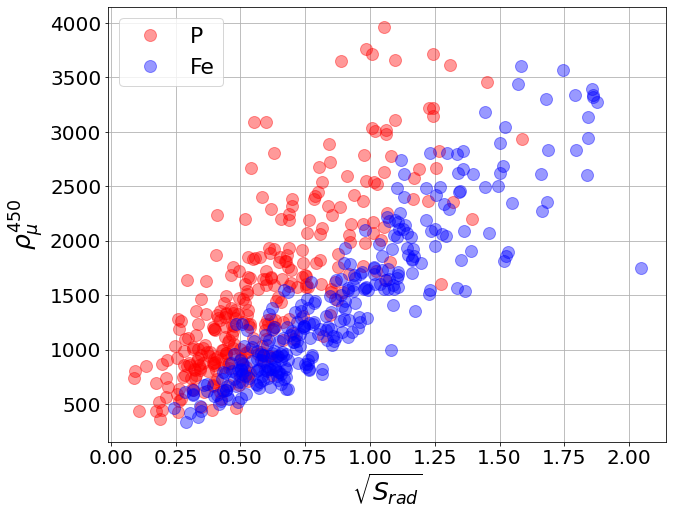

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(dp['N_mu_ref'], np.sqrt(dp["GeoCe Erad"]), 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(df['N_mu_ref'], np.sqrt(df["GeoCe Erad"]), 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()
plt.show()

<AxesSubplot:>

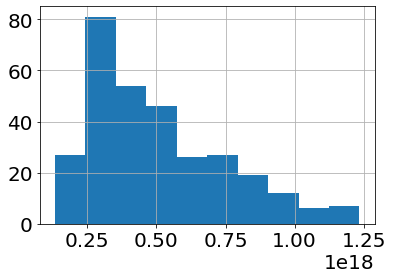

In [22]:
df["MC energy"].hist()

In [23]:
len(df)

305

In [24]:
len(dp)

305

<AxesSubplot:>

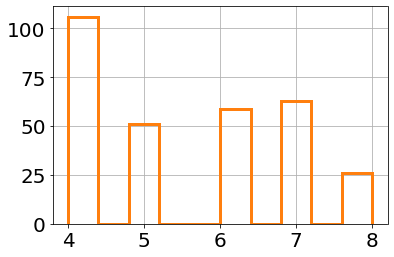

In [25]:
#Iron
df["antennas_cut"] = pd.cut(df["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

df["antennas_cut"].hist(histtype='step',linewidth=3, label="Antenas")

#Proton

dp["antennas_cut"] = pd.cut(dp["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

dp["antennas_cut"].hist(histtype='step',linewidth=3, label="Antenas")

In [26]:
df["antennas_cut"].value_counts()

4    106
7     63
6     59
5     51
8     26
Name: antennas_cut, dtype: int64

In [27]:
dp["antennas_cut"].value_counts()

4    106
7     63
6     59
5     51
8     26
Name: antennas_cut, dtype: int64

In [28]:
#### Iron

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=224466)
for train_index, test_index in split.split(df, df["antennas_cut"]):
    train_set_fe = df.loc[train_index]
    test_set_fe = df.loc[test_index]
    
train_set_fe=train_set_fe.drop(["antennas_cut"], axis=1)
test_set_fe=test_set_fe.drop(["antennas_cut"], axis=1)
print(train_set_fe.shape, test_set_fe.shape)

(244, 63) (61, 63)


In [29]:
#### Proton

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(dp, dp["antennas_cut"]):
    train_set_pr = dp.loc[train_index]
    test_set_pr = dp.loc[test_index]
    
train_set_pr=train_set_pr.drop(["antennas_cut"], axis=1)
test_set_pr=test_set_pr.drop(["antennas_cut"], axis=1)
print(train_set_pr.shape, test_set_pr.shape)

(244, 63) (61, 63)


In [30]:
### Contanetando data set
f_train = [train_set_fe, train_set_pr]
f_test = [test_set_fe, test_set_pr]

df_train_ = pd.concat(f_train)
df_test_ = pd.concat(f_test)

print(df_train_.shape, df_test_.shape)
df_train_.head()

(488, 63) (122, 63)


,runnr,MC energy,MC zenith,MC azimuth,MC Xmax,MC core x,MC core y,MC core z,Sd rec success,Sd energy,...,MLDF NDF,MLDF Likelihood,M beta,M beta error,M beta syst,pvalueMd,EnergyRd,Mu_rootSrad,rootSrad,target
246,104205,3.824250e+17,50.0277,332.231,606.878,449654,6113980.0,1468.62,1,3.718930e+17,...,15,10.3269,0.625931,0.309216,0,0.342569,2.963127e+17,0.000717,1186.642322,1
76,101420,7.590210e+17,50.6696,252.789,615.647,448851,6114320.0,1478.28,1,5.112060e+17,...,26,17.2197,0.964079,0.189909,0,0.304324,5.784101e+17,0.000495,2251.384019,1
171,102730,6.116010e+17,40.6307,285.853,616.988,449204,6114370.0,1473.42,1,4.199210e+17,...,24,17.0630,0.588354,0.280413,0,0.328039,4.665071e+17,0.000614,1867.359098,1
191,103178,3.842740e+17,53.6568,218.822,601.143,450980,6114150.0,1460.45,1,2.665860e+17,...,15,10.9482,0.000097,2.893310,0,0.445807,3.314039e+17,0.000461,1327.143549,1
75,101416,9.452550e+17,49.0955,355.084,636.076,449628,6113950.0,1467.00,1,6.682260e+17,...,27,10.3834,1.490790,0.183751,0,0.765089,7.529746e+17,0.000438,2809.946619,1


In [31]:
df_train = df_train_.copy()
df_test = df_test_.copy()

In [32]:
#Features

df_train_1 = df_train[["rootSrad", "N_mu_ref", "target"]]
df_test_1 = df_test[["rootSrad", "N_mu_ref", "target"]]

In [33]:
print(df_train_1.shape, df_test_1.shape)

(488, 3) (122, 3)


In [34]:
df_train_1.head()

,rootSrad,N_mu_ref,target
246,1186.642322,0.850606,1
76,2251.384019,1.114180,1
171,1867.359098,1.146870,1
191,1327.143549,0.612265,1
75,2809.946619,1.232080,1


In [35]:
corr_matrix = df_train_1.corr()
corr_matrix["target"].sort_values(ascending=False)

target      1.000000
N_mu_ref    0.384449
rootSrad   -0.057361
Name: target, dtype: float64

In [36]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_1.drop("target", axis=1) 
df_train_labels = df_train_1["target"].copy()

df_test_aux = df_test_1.drop("target", axis=1) 
df_test_labels = df_test_1["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_test_aux.shape, df_test_labels.shape)

(488, 2) (488,) (122, 2) (122,)


In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [38]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [39]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [40]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [41]:
X_train.head()

,rootSrad,N_mu_ref
0,-0.190732,0.462230
1,1.100626,1.066291
2,0.722051,1.133262
3,0.033892,-0.224563
4,1.550809,1.301173


In [42]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

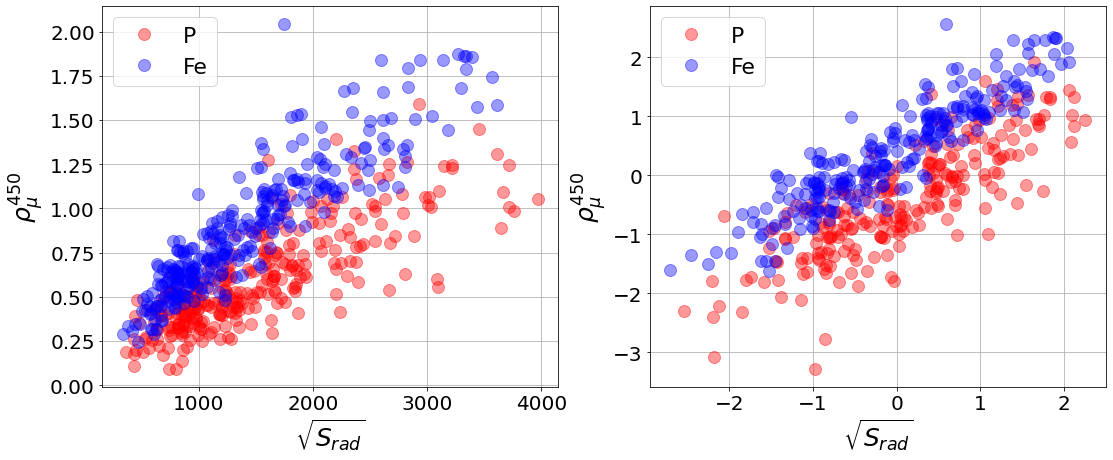

In [43]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(np.sqrt(dp["GeoCe Erad"]), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.sqrt(df["GeoCe Erad"]), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$ \sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==-1, 0], XX[yy==-1, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$ \sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [44]:
XX_=X_test.select_dtypes(include=float).to_numpy()
yy_=y_test

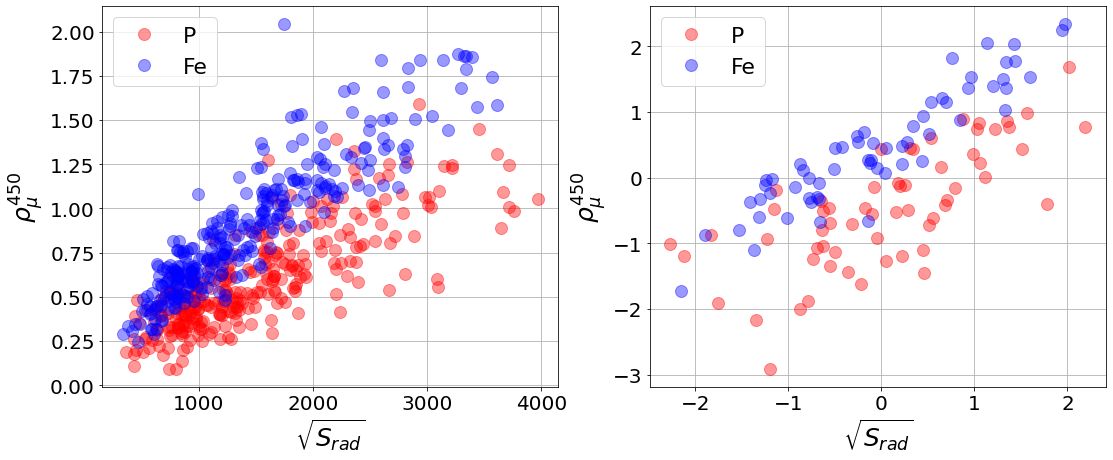

In [45]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(np.sqrt(dp["GeoCe Erad"]), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.sqrt(df["GeoCe Erad"]), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$ \sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX_[yy_==-1, 0], XX_[yy_==-1, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX_[yy_==1, 0], XX_[yy_==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$ \sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [46]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(np.sqrt(dp["GeoCe Erad"]), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(np.sqrt(df["GeoCe Erad"]), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[y==-1, 0], Xss[y==-1, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[y==1, 0], Xss[y==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 2.5, "(b)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(0, 12E3, 25)
    plt.hist(np.sqrt(dp["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(np.sqrt(df["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-3, 3, 20)
    plt.hist(Xss[y==-1, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 4, 20)
    plt.hist(dp['N_mu_ref'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['N_mu_ref'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==-1, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

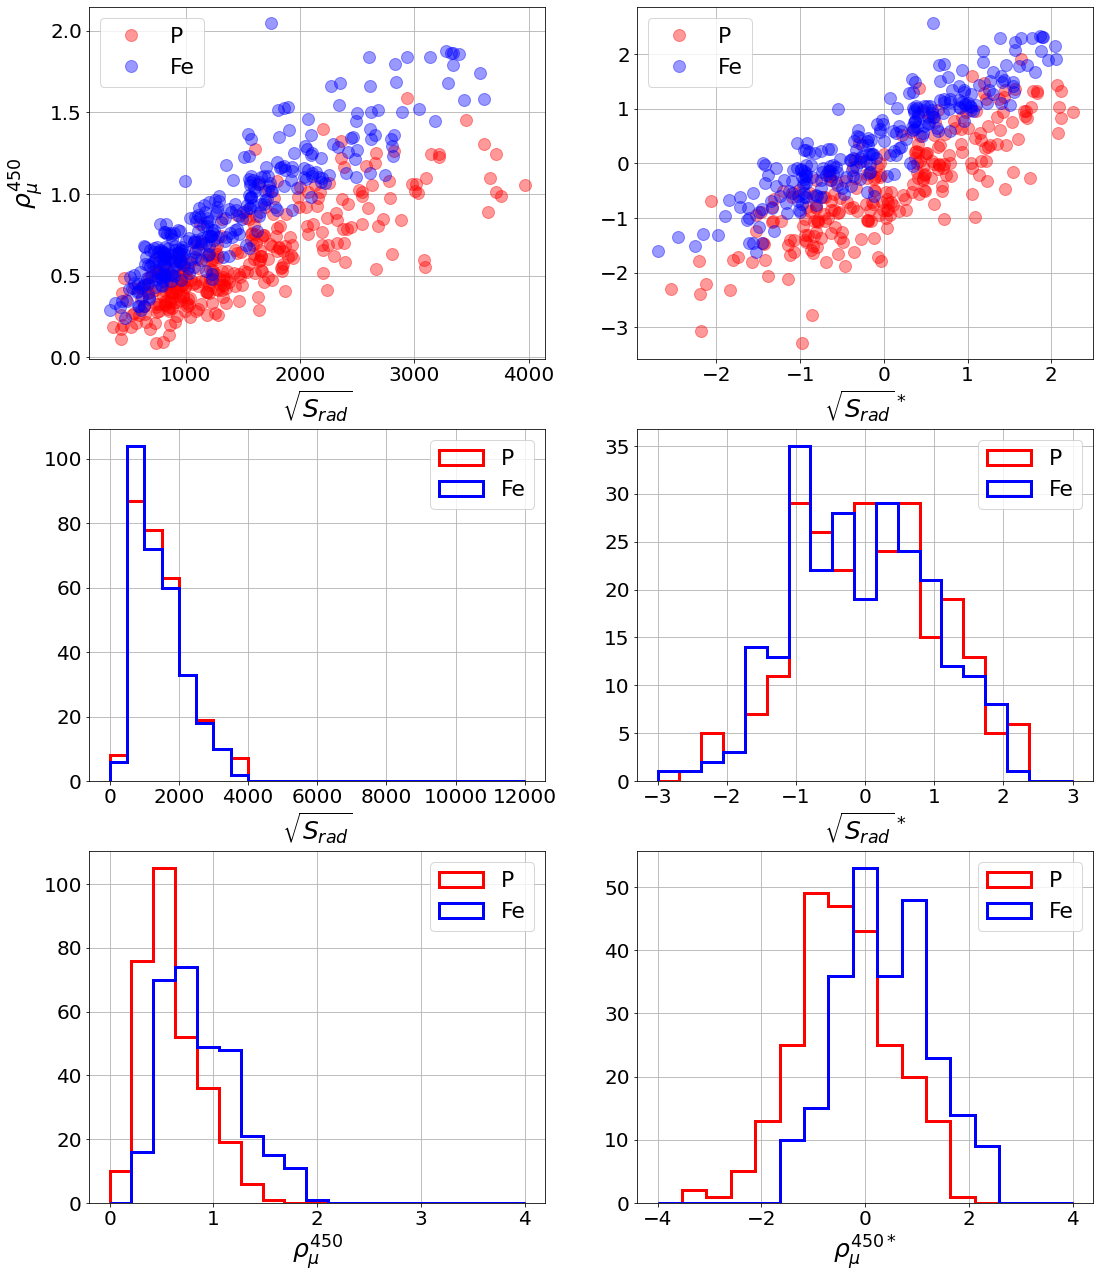

In [47]:
escala(PowerTransformer(method='box-cox'))
#plt.savefig("scaler_observable_1.png", dpi=300)

In [48]:
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [146]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l2', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 1000)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=100, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l2',
                                         

In [147]:
model_Log_1 = rnd_search_cv.best_estimator_
model_Log_1

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=388.83602826218845, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [148]:
print(accuracy(X_train, y_train, model_Log_1))
print(crossAccuracy(X_train, y_train, model_Log_1))

0.8545081967213115
Accuracy:  0.85046768707483 0.07284344611134401
presicion:  0.8393701119525707 0.06893533790004032
recall:  0.8690000000000001 0.09680507332894399
F1_score:  0.8522636269727124 0.07530319510006123
None


In [149]:
mconfusion(X_train, y_train, model_Log_1)

Matriz de confusión, 

[[203  41]
 [ 32 212]]
precisión:  0.8379446640316206
exhaustividad:  0.8688524590163934


In [150]:
print(crossAccuracy(X_test, y_test, model_Log_1))

Accuracy:  0.8301282051282051 0.12476967603491111
presicion:  0.8304761904761906 0.12939682150256238
recall:  0.8523809523809522 0.15714285714285714
F1_score:  0.8325029872088695 0.12488188985889467
None


In [151]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_1.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.87      0.83      0.85       244
           1       0.84      0.88      0.86       244

    accuracy                           0.85       488
   macro avg       0.86      0.85      0.85       488
weighted avg       0.86      0.85      0.85       488



In [264]:
ypred = cross_val_predict(model_Log_1, X_train, y_train, cv=5, method="decision_function")

In [265]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

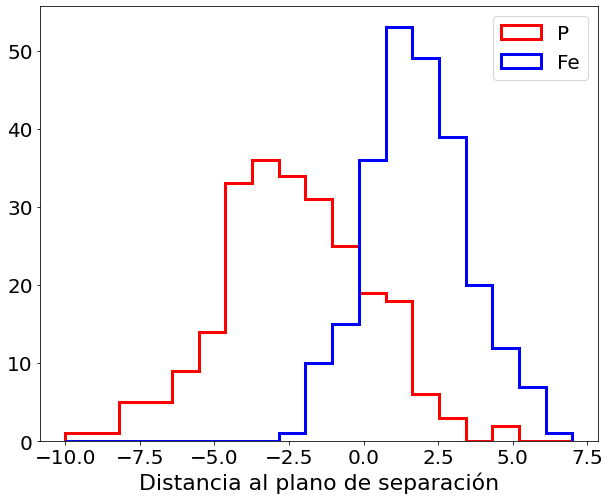

In [266]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 7, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
plt.savefig("obs_1_RL_lin_hist.png", dpi=300)

In [267]:
boostMF(c1_pred, c2_pred)

('1.37', '0.08')

In [156]:
lr=model_Log_1.named_steps['logi_clf']

Saving figure obs_1_RL_lin_plano


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


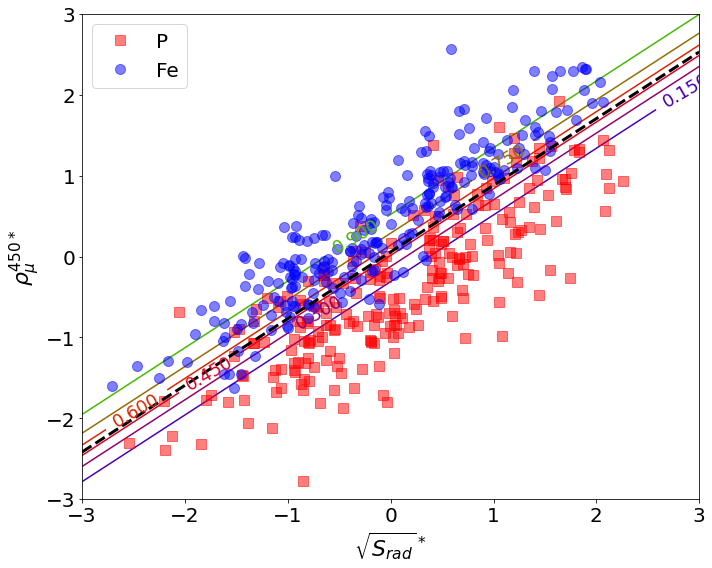

In [157]:
X=X_train
y=y_train

log_reg = model_Log_1.named_steps['logi_clf']

x0, x1 = np.meshgrid(
        np.linspace(-3, 3, 500).reshape(-1, 1),
        np.linspace(-3, 3, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==-1, 0], XX[yy==-1, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$ \sqrt{S_{rad}}^*$", fontsize=22)
plt.ylabel(r"$\rho^{450*}_{\mu}$", fontsize=22)
plt.axis([-3, 3, -3, 3])
save_fig("obs_1_RL_lin_plano")
plt.show()

In [158]:
from sklearn.preprocessing import PolynomialFeatures

In [736]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [737]:
X_poly2_test = poly2.fit_transform(X_test)

In [738]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l2', solver='newton-cg', 
                                        tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=10, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [739]:
model_Log_2 = rnd_search_cv.best_estimator_
model_Log_2

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=5.125728481417311, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='newton-cg', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [740]:
print(accuracy(X_poly2, y_train, model_Log_2))
print(crossAccuracy(X_poly2, y_train, model_Log_2))

0.8524590163934426
Accuracy:  0.8422619047619048 0.06552034909896509
presicion:  0.8172549487549488 0.061476020721603956
recall:  0.8855000000000001 0.08285881566455881
F1_score:  0.8486265640934316 0.06420700816060201
None


In [741]:
mconfusion(X_poly2, y_train, model_Log_2)

Matriz de confusión, 

[[195  49]
 [ 28 216]]
precisión:  0.8150943396226416
exhaustividad:  0.8852459016393442


In [742]:
print(crossAccuracy(X_poly2_test, y_test, model_Log_2))

Accuracy:  0.8307692307692308 0.1151778774689443
presicion:  0.8238311688311688 0.1272879827856744
recall:  0.8857142857142858 0.12945025922922082
F1_score:  0.8421711621711621 0.09054698166954638
None


In [743]:
print(classification_report(y_train, model_Log_2.predict(X_poly2)))

              precision    recall  f1-score   support

          -1       0.88      0.81      0.85       244
           1       0.83      0.89      0.86       244

    accuracy                           0.85       488
   macro avg       0.85      0.85      0.85       488
weighted avg       0.85      0.85      0.85       488



In [744]:
ypred = cross_val_predict(model_Log_2, X_poly2, y_train, cv=5, method="decision_function")

In [745]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

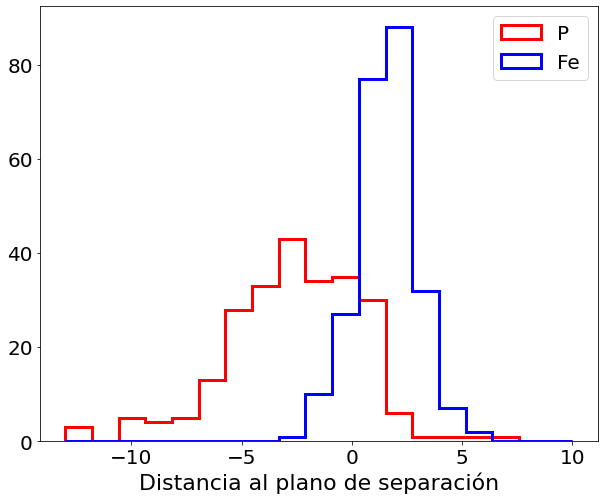

In [748]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-13, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
plt.savefig("obs_1_RL_poly_hist.png", dpi=300)

In [749]:
boostMF(c1_pred, c2_pred)

('1.26', '0.08')

## SVM

In [151]:
from sklearn import svm
from sklearn.svm import LinearSVC

In [152]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 10), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [153]:
model_svm_1 = rnd_search_cv.best_estimator_
model_svm_1

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=17.141646569475935, break_ties=False, cache_size=200,
                     class_weight=None, coef0=70.84247398941778,
                     decision_function_shape='ovr', degree=3,
                     gamma=9.230904086627655e-05, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [154]:
print(accuracy(X_train, y_train, model_svm_1))
print(crossAccuracy(X_train, y_train, model_svm_1))

0.8360655737704918
Accuracy:  0.8360544217687075 0.05822290771853845
presicion:  0.8071704961704962 0.061051836181542994
recall:  0.8895 0.06814628872261987
F1_score:  0.8448844404858411 0.054317317980431955
None


In [155]:
print(crossAccuracy(X_test, y_test, model_svm_1))

Accuracy:  0.8467948717948719 0.11835388881666546
presicion:  0.8521428571428572 0.136353756599426
recall:  0.869047619047619 0.12428936320131609
F1_score:  0.8528060175118999 0.10710439888311622
None


In [156]:
mconfusion(X_train, y_train, model_svm_1)

Matriz de confusión, 

[[191  53]
 [ 27 217]]
precisión:  0.8037037037037037
exhaustividad:  0.889344262295082


In [157]:
print(classification_report(y_train, model_svm_1.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.88      0.78      0.83       244
           1       0.80      0.89      0.84       244

    accuracy                           0.84       488
   macro avg       0.84      0.84      0.84       488
weighted avg       0.84      0.84      0.84       488



In [158]:
ypred = cross_val_predict(model_svm_1, X_train, y_train, cv=5, method="decision_function")

In [159]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

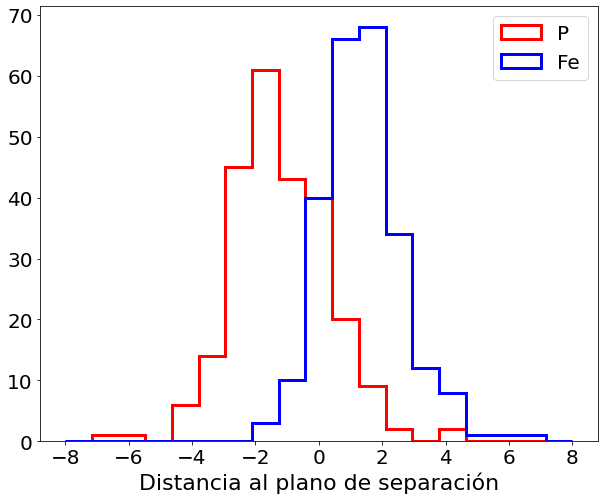

In [160]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-8, 8, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
plt.savefig("obs_1_SVM_lin_hist.png", dpi=300)

In [161]:
boostMF(c1_pred, c2_pred)

('1.30', '0.08')

In [162]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.RdYlBu, alpha=0.3)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.RdYlBu, alpha=0.3)

Saving figure obs_1_SVM_lin_plano


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


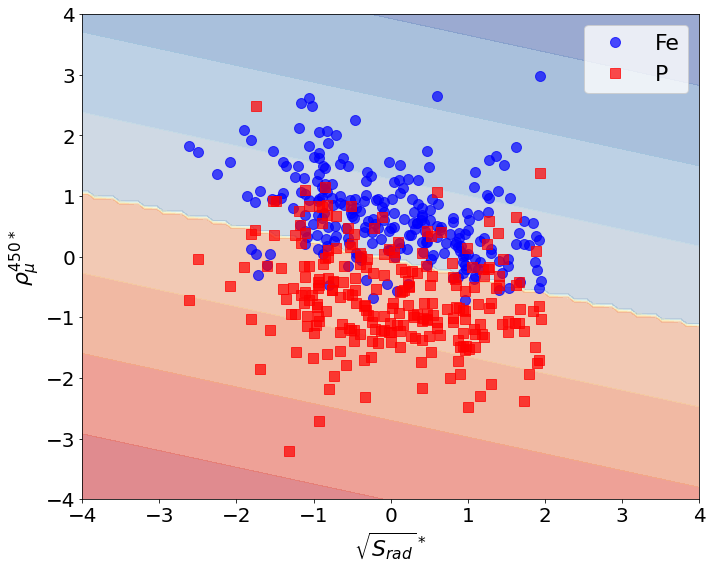

In [163]:
plt.figure(figsize=(10, 8))
plot_predictions(model_svm_1, [-4, 4, -4, 4])
plt.plot(XX[:, 0][yy==1], XX[:, 1][yy==1], "bo", markersize=10, alpha=0.7, label="Fe")
plt.plot(XX[:, 0][yy==-1], XX[:, 1][yy==-1], "rs", markersize=10, alpha=0.7, label="P")
plt.xlabel(r"$ \sqrt{S_{rad}}^*$", fontsize=22)
plt.ylabel(r"$\rho^{450*}_{\mu}$", fontsize=22)
plt.legend(fontsize=22)
save_fig("obs_1_SVM_lin_plano")
plt.show()

In [164]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [165]:
model_svm_1p = rnd_search_cv.best_estimator_
model_svm_1p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=95.71167007322167, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [166]:
print(accuracy(X_train, y_train, model_svm_1p))
print(crossAccuracy(X_train, y_train, model_svm_1p))

0.8135245901639344
Accuracy:  0.8054846938775511 0.0548826052096438
presicion:  0.7402662639085053 0.05837408695995378
recall:  0.9546666666666667 0.03428475527759305
F1_score:  0.8324138980398825 0.040158197783926666
None


In [167]:
print(crossAccuracy(X_test, y_test, model_svm_1p))

Accuracy:  0.7461538461538462 0.10708006675805692
presicion:  0.8454761904761904 0.13710833725607174
recall:  0.6547619047619049 0.2839728676637277
F1_score:  0.6851936951936951 0.19497540943985592
None


In [168]:
mconfusion(X_train, y_train, model_svm_1p)

Matriz de confusión, 

[[160  84]
 [ 11 233]]
precisión:  0.7350157728706624
exhaustividad:  0.9549180327868853


In [169]:
print(classification_report(y_train, model_svm_1p.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.95      0.66      0.78       244
           1       0.74      0.96      0.84       244

    accuracy                           0.81       488
   macro avg       0.84      0.81      0.81       488
weighted avg       0.84      0.81      0.81       488



In [170]:
ypred = cross_val_predict(model_svm_1p, X_train, y_train, cv=5, method="decision_function")

In [171]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

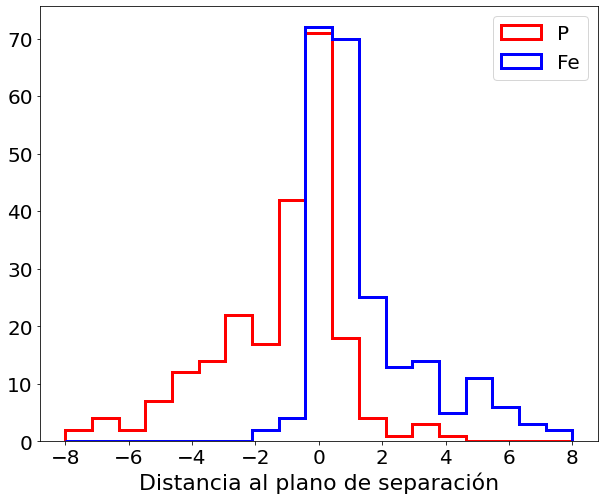

In [172]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-8, 8, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
plt.savefig("obs_1_SVM_poly_hist.png", dpi=300)

In [173]:
boostMF(c1_pred, c2_pred)

('0.53', '0.08')

Saving figure obs_1_SVM_poly_plano


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


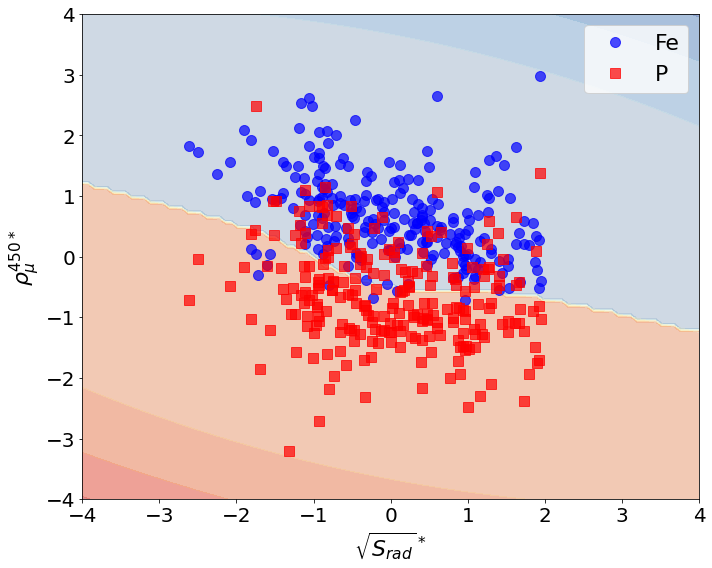

In [174]:
plt.figure(figsize=(10, 8))
plot_predictions(model_svm_1p, [-4, 4, -4, 4])
plt.plot(XX[:, 0][yy==1], XX[:, 1][yy==1], "bo", markersize=10, alpha=0.7, label="Fe")
plt.plot(XX[:, 0][yy==-1], XX[:, 1][yy==-1], "rs", markersize=10, alpha=0.7, label="P")
plt.xlabel(r"$ \sqrt{S_{rad}}^*$", fontsize=22)
plt.ylabel(r"$\rho^{450*}_{\mu}$", fontsize=22)
plt.legend(fontsize=22)
save_fig("obs_1_SVM_poly_plano")
plt.show()

In [175]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, max_iter=100000, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100),
                      "svm_clf__coef0": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=100000,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated',...
                

In [176]:
model_svm_2 = rnd_search_cv.best_estimator_
model_svm_2

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=46.88388332680019, break_ties=False, cache_size=200,
                     class_weight=None, coef0=71.23843898949883,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.00010749003098993417, kernel='rbf',
                     max_iter=100000, probability=True, random_state=369,
                     shrinking=True, tol=1e-08, verbose=False))],
         verbose=False)

In [177]:
print(accuracy(X_train, y_train, model_svm_2))
print(crossAccuracy(X_train, y_train, model_svm_2))

0.8340163934426229
Accuracy:  0.8341411564625851 0.03569324878483003
presicion:  0.7976210317460317 0.04992621827767906
recall:  0.9014999999999999 0.02070225430559033
F1_score:  0.8454670427417084 0.029100131981463568
None


In [178]:
print(accuracy(X_test, y_test, model_svm_2))
print(crossAccuracy(X_test, y_test, model_svm_2))

0.8442622950819673
Accuracy:  0.839102564102564 0.12378435842171288
presicion:  0.8214502164502164 0.12686458876538756
recall:  0.9023809523809524 0.10934250003052413
F1_score:  0.8531968031968032 0.09870957982726421
None


In [179]:
mconfusion(X_train, y_train, model_svm_2)

Matriz de confusión, 

[[187  57]
 [ 24 220]]
precisión:  0.7942238267148014
exhaustividad:  0.9016393442622951


In [180]:
print(classification_report(y_train, model_svm_2.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.89      0.77      0.82       244
           1       0.79      0.90      0.84       244

    accuracy                           0.83       488
   macro avg       0.84      0.83      0.83       488
weighted avg       0.84      0.83      0.83       488



In [181]:
ypred = cross_val_predict(model_svm_2, X_train, y_train, cv=5, method="decision_function")

In [182]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

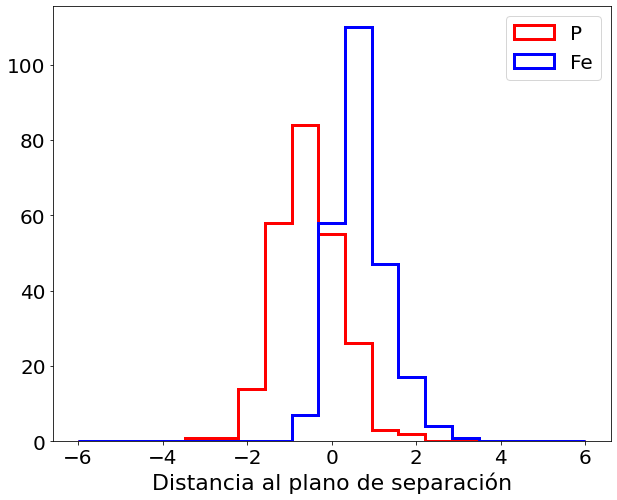

In [183]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
plt.savefig("obs_1_SVM_RBF_hist.png", dpi=300)

In [184]:
boostMF(c1_pred, c2_pred)

('1.30', '0.08')

Saving figure obs_1_SVM_RBF_plano


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


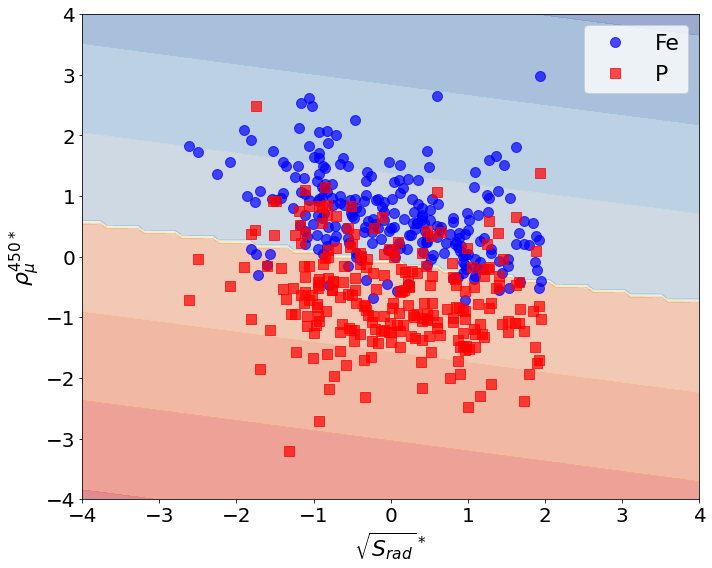

In [185]:
plt.figure(figsize=(10, 8))
plot_predictions(model_svm_2, [-4, 4, -4, 4])
plt.plot(XX[:, 0][yy==1], XX[:, 1][yy==1], "bo", markersize=10, alpha=0.7, label="Fe")
plt.plot(XX[:, 0][yy==-1], XX[:, 1][yy==-1], "rs", markersize=10, alpha=0.7, label="P")
plt.xlabel(r"$ \sqrt{S_{rad}}^*$", fontsize=22)
plt.ylabel(r"$\rho^{450*}_{\mu}$", fontsize=22)
plt.legend(fontsize=22)
save_fig("obs_1_SVM_RBF_plano")
plt.show()

In [186]:
svcP=model_svm_2.named_steps['svm_clf']

NameError: name 'y' is not defined

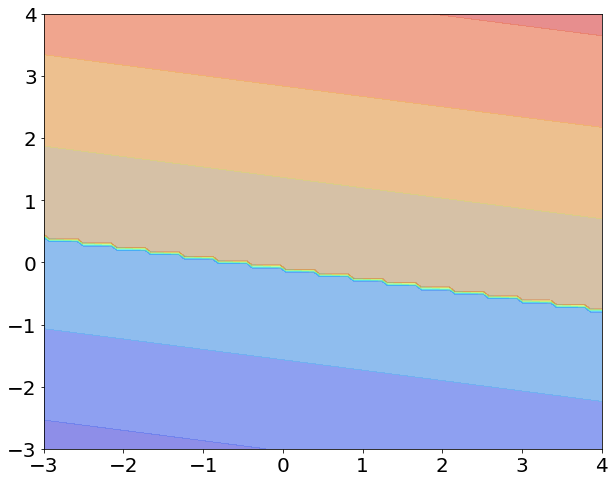

In [187]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==-1, 0], XX[yy==-1, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.3)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.2)
    

plt.figure(figsize=(10, 8))
plot_predictions(svcP,[-3, 4, -3, 4])
plot_dataset(XX, y,[-3, 4, -3, 4])
plt.xlabel(r"$\sqrt{S_{rad}}$")
plt.ylabel(r"$\rho^{450}_{\mu}$")

plt.show()

### Test

#### RL linear

In [843]:
print(crossAccuracy(X_train, y_train, model_Log_1))

Accuracy:  0.85046768707483 0.07284344611134401
presicion:  0.8393701119525707 0.06893533790004032
recall:  0.8690000000000001 0.09680507332894399
F1_score:  0.8522636269727124 0.07530319510006123
None


In [844]:
auc_cv(X_train, y_train, model_Log_1)

0.9199097222222223 0.04253019590429141


In [845]:
print(crossAccuracy(X_test, y_test, model_Log_1))

Accuracy:  0.8301282051282051 0.12476967603491111
presicion:  0.8304761904761906 0.12939682150256238
recall:  0.8523809523809522 0.15714285714285714
F1_score:  0.8325029872088695 0.12488188985889467
None


In [846]:
auc_cv(X_test, y_test, model_Log_1)

0.9126984126984128 0.08186537751255632


#### RL poly

In [847]:
print(crossAccuracy(X_poly2, y_train, model_Log_2))

Accuracy:  0.8422619047619048 0.06552034909896509
presicion:  0.8172549487549488 0.061476020721603956
recall:  0.8855000000000001 0.08285881566455881
F1_score:  0.8486265640934316 0.06420700816060201
None


In [848]:
auc_cv(X_poly2, y_train, model_Log_2)

0.9213402777777778 0.042564811352915184


In [849]:
print(crossAccuracy(X_test, y_test, model_Log_2))

Accuracy:  0.8301282051282051 0.12476967603491111
presicion:  0.8304761904761906 0.12939682150256238
recall:  0.8523809523809522 0.15714285714285714
F1_score:  0.8325029872088695 0.12488188985889467
None


In [850]:
auc_cv(X_poly2_test, y_test, model_Log_2)

0.9261904761904762 0.0795474096084179


#### SVM linear

In [851]:
print(crossAccuracy(X_train, y_train, model_svm_1))

Accuracy:  0.8464285714285713 0.06984311038008288
presicion:  0.8231784592219376 0.07319180582525338
recall:  0.8895 0.08535562859784547
F1_score:  0.8530294848449029 0.0675444616623374
None


In [852]:
auc_cv(X_train, y_train, model_svm_1)

0.9201562500000001 0.04262110912896903


In [853]:
print(crossAccuracy(X_test, y_test, model_svm_1))

Accuracy:  0.8384615384615385 0.10990552394947582
presicion:  0.837857142857143 0.12729725777382125
recall:  0.869047619047619 0.12428936320131609
F1_score:  0.8451137098195922 0.09868826592509697
None


In [854]:
auc_cv(X_test, y_test, model_svm_1)

0.909920634920635 0.07928666761426952


#### SVM poly

In [855]:
print(crossAccuracy(X_train, y_train, model_svm_1p))

Accuracy:  0.8299319727891156 0.07302857529721023
presicion:  0.7869606073345932 0.08309112604529592
recall:  0.922 0.06157560844649084
F1_score:  0.8466244522933961 0.06086205370860755
None


In [856]:
auc_cv(X_train, y_train, model_svm_1p)

0.9095208333333332 0.0494873453279525


In [857]:
print(crossAccuracy(X_test, y_test, model_svm_1p))

Accuracy:  0.8128205128205129 0.10625568012817162
presicion:  0.7888095238095237 0.10668712601407378
recall:  0.8857142857142858 0.16693855374245817
F1_score:  0.8225762472821296 0.10626652527782446
None


In [858]:
auc_cv(X_test, y_test, model_svm_1p)

0.8992063492063492 0.1024885616340186


#### SVM gaussiano

In [859]:
print(crossAccuracy(X_train, y_train, model_svm_2))

Accuracy:  0.8483843537414966 0.06754698695235636
presicion:  0.8197762952245711 0.06476595392029921
recall:  0.8976666666666666 0.08161631100596389
F1_score:  0.8555865963243535 0.06497203834075152
None


In [860]:
auc_cv(X_train, y_train, model_svm_2)

0.9207847222222222 0.042845658286783016


In [861]:
print(crossAccuracy(X_test, y_test, model_svm_2))

Accuracy:  0.8384615384615385 0.11605219982188056
presicion:  0.8211904761904762 0.11532488860594137
recall:  0.8857142857142858 0.12945025922922082
F1_score:  0.8466288613347437 0.10644865315009477
None


In [862]:
auc_cv(X_test, y_test, model_svm_2)

0.9261904761904762 0.07243993002363527


## Incluyendo la energía

In [49]:
#Features

df_train_2 = df_train[["MC energy", "Mu_rootSrad", "target"]]
df_test_2 = df_test[["MC energy", "Mu_rootSrad", "target"]]

In [50]:
print(df_train_2.shape, df_test_.shape)

(488, 3) (122, 63)


In [51]:
df_train_2.head()

,MC energy,Mu_rootSrad,target
246,3.824250e+17,0.000717,1
76,7.590210e+17,0.000495,1
171,6.116010e+17,0.000614,1
191,3.842740e+17,0.000461,1
75,9.452550e+17,0.000438,1


In [52]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target         1.000000
Mu_rootSrad    0.652022
MC energy     -0.005095
Name: target, dtype: float64

In [53]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 2) (488,) (488, 2) (122,)


In [54]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [55]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [56]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [57]:
X_train.head()

,MC energy,Mu_rootSrad
0,-0.324464,1.017026
1,1.092195,-0.177543
2,0.651643,0.492047
3,-0.314309,-0.380284
4,1.534527,-0.522815


In [58]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

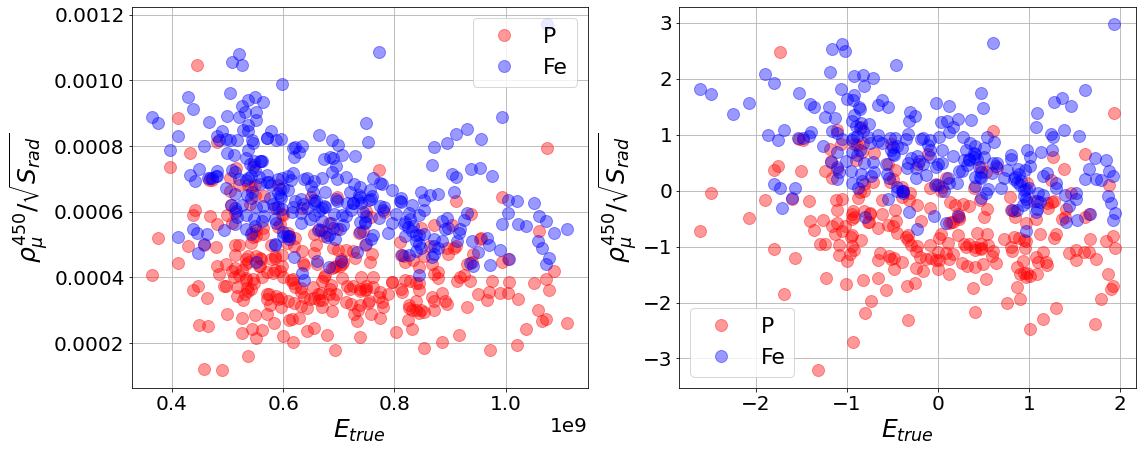

In [59]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(np.sqrt(dp["MC energy"]), dp['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.sqrt(df["MC energy"]), df['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==-1, 0], XX[yy==-1, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [129]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=100, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [130]:
model_Log_3 = rnd_search_cv.best_estimator_
model_Log_3

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=4.221070101152146, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [131]:
print(accuracy(X_train, y_train, model_Log_3))
print(crossAccuracy(X_train, y_train, model_Log_3))

0.8442622950819673
Accuracy:  0.838095238095238 0.05489694761731458
presicion:  0.8254813612183879 0.053242626089167834
recall:  0.8605 0.07424826971421997
F1_score:  0.8412773869304921 0.05547479042436802
None


In [132]:
auc_cv(X_train, y_train, model_Log_3)

0.912326388888889 0.040380774082591074


In [133]:
print(crossAccuracy(X_test, y_test, model_Log_3))

Accuracy:  0.8301282051282051 0.12476967603491111
presicion:  0.8304761904761906 0.12939682150256238
recall:  0.8523809523809522 0.15714285714285714
F1_score:  0.8325029872088695 0.12488188985889467
None


In [134]:
auc_cv(X_test, y_test, model_Log_3)

0.9051587301587303 0.07939384399370489


In [135]:
mconfusion(X_train, y_train, model_Log_3)

Matriz de confusión, 

[[199  45]
 [ 34 210]]
precisión:  0.8235294117647058
exhaustividad:  0.860655737704918


In [136]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_3.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.86      0.82      0.84       244
           1       0.83      0.86      0.85       244

    accuracy                           0.84       488
   macro avg       0.84      0.84      0.84       488
weighted avg       0.84      0.84      0.84       488



In [137]:
ypred = cross_val_predict(model_Log_3, X_train, y_train, cv=5, method="decision_function")

In [138]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

Saving figure obs_1_hist_best


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


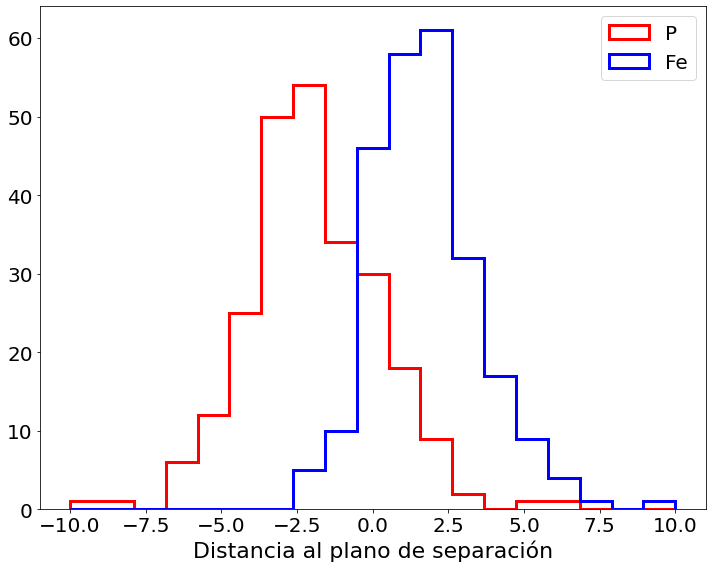

In [147]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
#save_fig("obs_1_hist_best")
plt.show()

In [148]:
boostMF(c1_pred, c2_pred)

('1.31', '0.08')

In [141]:
lr=model_Log_3.named_steps['logi_clf']

Saving figure plano_reglog_plot_best


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


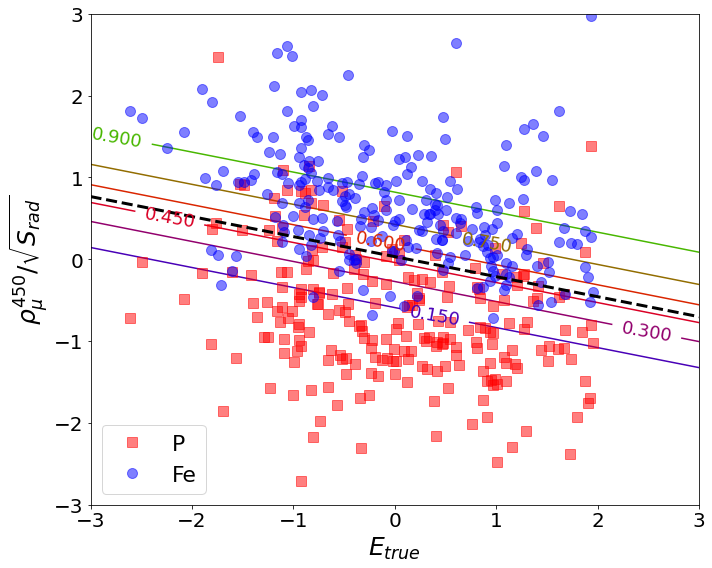

In [145]:
log_reg = model_Log_3.named_steps['logi_clf']

x0, x1 = np.meshgrid(
        np.linspace(-3, 3, 500).reshape(-1, 1),
        np.linspace(-3, 3, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==-1, 0], XX[yy==-1, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=22)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
plt.axis([-3, 3, -3, 3])
#save_fig("plano_reglog_plot_best")
plt.show()

In [146]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

NameError: name 'PolynomialFeatures' is not defined

In [348]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [349]:
model_Log_4 = rnd_search_cv.best_estimator_
model_Log_4

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=751.7432546689183, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [350]:
print(accuracy(X_poly2, y_train, model_Log_4))
print(crossAccuracy(X_poly2, y_train, model_Log_4))

0.8299180327868853
Accuracy:  0.8258928571428571 0.059014233391746204
presicion:  0.7941477041477042 0.06117207826073557
recall:  0.8855000000000001 0.06457145051973219
F1_score:  0.8362373828238795 0.05490628320875218
None


In [351]:
mconfusion(X_poly2, y_train, model_Log_4)

Matriz de confusión, 

[[187  57]
 [ 28 216]]
precisión:  0.7912087912087912
exhaustividad:  0.8852459016393442


In [352]:
print(classification_report(y_train, model_Log_4.predict(X_poly2)))

              precision    recall  f1-score   support

          -1       0.87      0.77      0.82       244
           1       0.80      0.89      0.84       244

    accuracy                           0.83       488
   macro avg       0.83      0.83      0.83       488
weighted avg       0.83      0.83      0.83       488



In [353]:
ypred = cross_val_predict(model_Log_4, X_poly2, y_train, cv=5, method="decision_function")

In [354]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

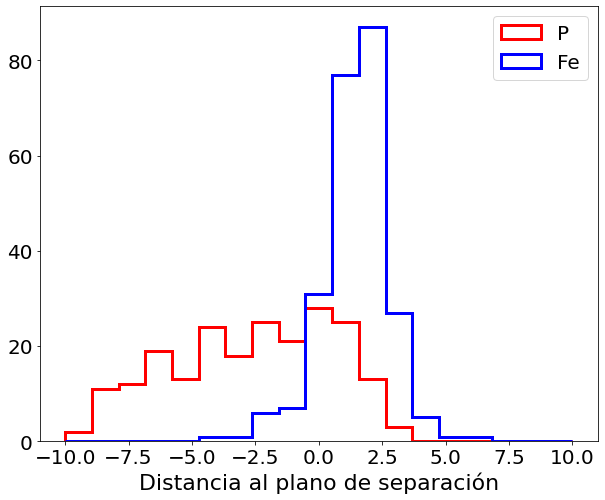

In [355]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [356]:
boostMF(c1_pred, c2_pred)

('0.73', '0.14')

## SVM

In [116]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 10), "svm_clf__C": uniform(0.1, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [117]:
model_svm_3 = rnd_search_cv.best_estimator_
model_svm_3

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=10.058771537488838, break_ties=False, cache_size=200,
                     class_weight=None, coef0=88.66467917009493,
                     decision_function_shape='ovr', degree=3,
                     gamma=8.997124122470037e-06, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [118]:
print(accuracy(X_train, y_train, model_svm_3))
print(crossAccuracy(X_train, y_train, model_svm_3))

0.8360655737704918
Accuracy:  0.8360544217687075 0.05822290771853845
presicion:  0.8071704961704962 0.061051836181542994
recall:  0.8895 0.06814628872261987
F1_score:  0.8448844404858411 0.054317317980431955
None


In [119]:
auc_cv(X_train, y_train, model_svm_3)

0.9119861111111109 0.04128958071122351


In [120]:
print(crossAccuracy(X_test, y_test, model_svm_3))

Accuracy:  0.8467948717948719 0.11835388881666546
presicion:  0.8521428571428572 0.136353756599426
recall:  0.869047619047619 0.12428936320131609
F1_score:  0.8528060175118999 0.10710439888311622
None


In [121]:
auc_cv(X_test, y_test, model_svm_3)

0.9051587301587303 0.07939384399370487


In [361]:
mconfusion(X_train, y_train, model_svm_3)

Matriz de confusión, 

[[191  53]
 [ 27 217]]
precisión:  0.8037037037037037
exhaustividad:  0.889344262295082


In [362]:
print(classification_report(y_train, model_svm_3.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.88      0.78      0.83       244
           1       0.80      0.89      0.84       244

    accuracy                           0.84       488
   macro avg       0.84      0.84      0.84       488
weighted avg       0.84      0.84      0.84       488



In [363]:
ypred = cross_val_predict(model_svm_3, X_train, y_train, cv=5, method="decision_function")

In [365]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

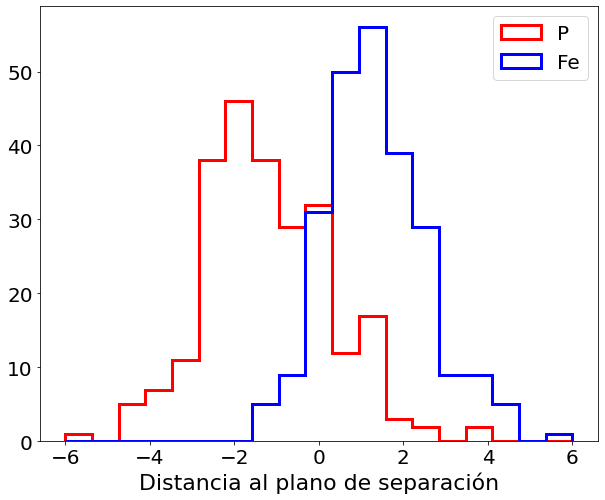

In [366]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [367]:
boostMF(c1_pred, c2_pred)

('1.31', '0.08')

In [369]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=10, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,


In [370]:
model_svm_3p = rnd_search_cv.best_estimator_
model_svm_3p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=965.4695630877129, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [371]:
print(accuracy(X_train, y_train, model_svm_3p))
print(crossAccuracy(X_train, y_train, model_svm_3p))

0.8135245901639344
Accuracy:  0.8054846938775511 0.0548826052096438
presicion:  0.7402662639085053 0.05837408695995378
recall:  0.9546666666666667 0.03428475527759305
F1_score:  0.8324138980398825 0.040158197783926666
None


In [372]:
mconfusion(X_train, y_train, model_svm_3p)

Matriz de confusión, 

[[160  84]
 [ 11 233]]
precisión:  0.7350157728706624
exhaustividad:  0.9549180327868853


In [373]:
print(classification_report(y_train, model_svm_3p.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.95      0.66      0.78       244
           1       0.74      0.96      0.84       244

    accuracy                           0.81       488
   macro avg       0.84      0.81      0.81       488
weighted avg       0.84      0.81      0.81       488



In [374]:
ypred = cross_val_predict(model_svm_3p, X_train, y_train, cv=5, method="decision_function")

In [375]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

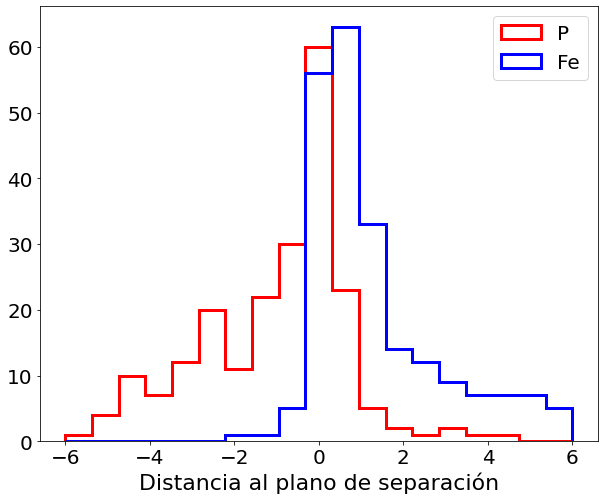

In [376]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [377]:
boostMF(c1_pred, c2_pred)

('0.53', '0.08')

In [68]:
from sklearn import svm

In [104]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [105]:
model_svm_4 = rnd_search_cv.best_estimator_
model_svm_4

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=3.8844138957069063, break_ties=False, cache_size=200,
                     class_weight=None, coef0=35.392212971296196,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.012816710578504326, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [106]:
print(accuracy(X_train, y_train, model_svm_4))
print(crossAccuracy(X_train, y_train, model_svm_4))

0.8360655737704918
Accuracy:  0.8360969387755102 0.06034457513160078
presicion:  0.8043534359956773 0.06128811645416934
recall:  0.8936666666666667 0.06334122757818254
F1_score:  0.8456641595500507 0.055862208019826914
None


In [107]:
auc_cv(X_train, y_train, model_svm_4)

0.9124930555555556 0.040449877177284564


In [108]:
print(crossAccuracy(X_test, y_test, model_svm_4))

Accuracy:  0.8384615384615385 0.11605219982188056
presicion:  0.8126190476190477 0.11968425012461395
recall:  0.9023809523809524 0.10934250003052413
F1_score:  0.8508246655305479 0.10241176093071624
None


In [92]:
auc_cv(X_test, y_test, model_svm_4)

0.9206349206349207 0.06948411565273264


In [93]:
mconfusion(X_train, y_train, model_svm_4)

Matriz de confusión, 

[[190  54]
 [ 26 218]]
precisión:  0.8014705882352942
exhaustividad:  0.8934426229508197


In [678]:
print(classification_report(y_train, model_svm_4.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.88      0.79      0.83       244
           1       0.81      0.89      0.85       244

    accuracy                           0.84       488
   macro avg       0.84      0.84      0.84       488
weighted avg       0.84      0.84      0.84       488



In [679]:
ypred = cross_val_predict(model_svm_4, X_train, y_train, cv=5, method="decision_function")

In [680]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

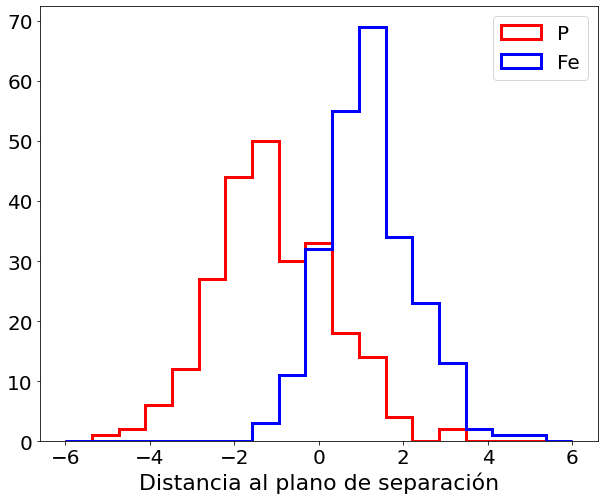

In [681]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [682]:
boostMF(c1_pred, c2_pred)

('1.33', '0.08')

In [683]:
svcP=model_svm_4.named_steps['svm_clf']

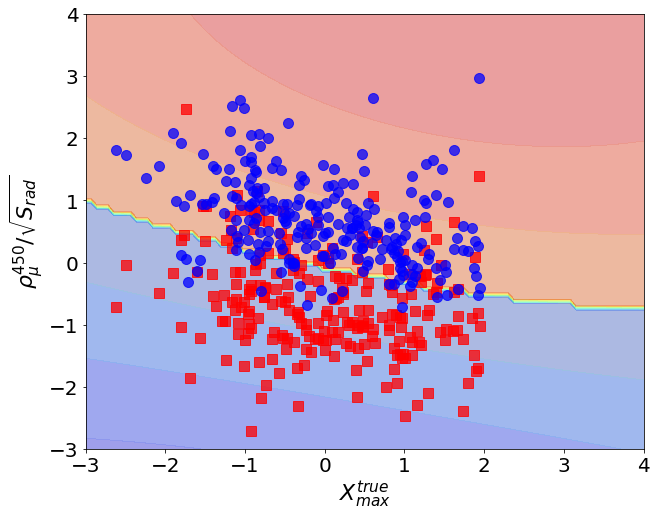

In [684]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==-1, 0], XX[yy==-1, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.3)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_4,[-3, 4, -3, 7])
plot_dataset(XX, y,[-3, 4, -3, 4])
plt.xlabel(r"$X^{true}_{max}$")
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$")

plt.show()

### Test

#### RL linear

In [621]:
print(crossAccuracy(X_train, y_train, model_Log_3))

Accuracy:  0.8360544217687075 0.05603580200624784
presicion:  0.8246908473843957 0.05328643334880213
recall:  0.8563333333333334 0.07901054781905176
F1_score:  0.8386871926659223 0.05751155378126272
None


In [622]:
auc_cv(X_train, y_train, model_Log_3)

0.9119930555555555 0.040700014432043116


In [623]:
print(crossAccuracy(X_test, y_test, model_Log_3))

Accuracy:  0.8301282051282051 0.12476967603491111
presicion:  0.8304761904761906 0.12939682150256238
recall:  0.8523809523809522 0.15714285714285714
F1_score:  0.8325029872088695 0.12488188985889467
None


In [624]:
auc_cv(X_test, y_test, model_Log_3)

0.9051587301587303 0.07939384399370489


#### RL poly

In [625]:
print(crossAccuracy(X_poly2, y_train, model_Log_4))

Accuracy:  0.8300170068027212 0.06476913046353455
presicion:  0.8233379253596645 0.06635251526201073
recall:  0.8443333333333334 0.06818357573492315
F1_score:  0.8327648277707567 0.06209840978782485
None


In [628]:
auc_cv(X_poly2, y_train, model_Log_4)

0.9147013888888889 0.03924339964260563


In [631]:
print(crossAccuracy(X_test, y_test, model_Log_4))

Accuracy:  0.8301282051282051 0.12476967603491111
presicion:  0.8304761904761906 0.12939682150256238
recall:  0.8523809523809522 0.15714285714285714
F1_score:  0.8325029872088695 0.12488188985889467
None


In [632]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [635]:
auc_cv(X_poly2_test, y_test, model_Log_4)

0.9321428571428573 0.07605083930325919


#### SVM linear

In [636]:
print(crossAccuracy(X_train, y_train, model_svm_3))

Accuracy:  0.8360544217687075 0.05822290771853845
presicion:  0.8071704961704962 0.061051836181542994
recall:  0.8895 0.06814628872261987
F1_score:  0.8448844404858411 0.054317317980431955
None


In [639]:
auc_cv(X_train, y_train, model_svm_3)

0.9119861111111109 0.04128958071122351


In [640]:
print(crossAccuracy(X_test, y_test, model_svm_3))

Accuracy:  0.8467948717948719 0.11835388881666546
presicion:  0.8521428571428572 0.136353756599426
recall:  0.869047619047619 0.12428936320131609
F1_score:  0.8528060175118999 0.10710439888311622
None


In [641]:
auc_cv(X_test, y_test, model_svm_3)

0.9051587301587303 0.07939384399370487


#### SVM poly

In [643]:
print(crossAccuracy(X_train, y_train, model_svm_3p))

Accuracy:  0.8054846938775511 0.0548826052096438
presicion:  0.7402662639085053 0.05837408695995378
recall:  0.9546666666666667 0.03428475527759305
F1_score:  0.8324138980398825 0.040158197783926666
None


In [644]:
auc_cv(X_train, y_train, model_svm_3p)

0.9032291666666667 0.04328194569236309


In [645]:
print(crossAccuracy(X_test, y_test, model_svm_3p))

Accuracy:  0.7378205128205129 0.10314140412035543
presicion:  0.8376839826839827 0.14625214380407206
recall:  0.6666666666666667 0.3073181485764296
F1_score:  0.6782095682095681 0.19353411908522475
None


In [646]:
auc_cv(X_test, y_test, model_svm_3p)

0.8853174603174603 0.09251139674978766


#### SVM gaussiano

In [647]:
print(crossAccuracy(X_train, y_train, model_svm_4))

Accuracy:  0.8360969387755102 0.0542864928261991
presicion:  0.806943179585421 0.05769574551902057
recall:  0.8895 0.06024510123007699
F1_score:  0.8450042956044724 0.05015612652200405
None


In [648]:
auc_cv(X_train, y_train, model_svm_4)

0.9111805555555555 0.03989101907419485


In [649]:
print(crossAccuracy(X_test, y_test, model_svm_4))

Accuracy:  0.8634615384615385 0.12111992470448771
presicion:  0.8554761904761905 0.1354427107346736
recall:  0.9023809523809524 0.10934250003052413
F1_score:  0.8725029872088695 0.10674852428965723
None


In [651]:
auc_cv(X_test, y_test, model_svm_4)

0.9285714285714285 0.06804138174397716


## Variables individuales + Energía

In [227]:
#Features

df_train_2 = df_train[["MC energy", "rootSrad", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "rootSrad", "N_mu_ref", "target"]]

In [228]:
print(df_train_2.shape, df_test_.shape)

(488, 4) (122, 63)


In [229]:
df_train_2.head()

,MC energy,rootSrad,N_mu_ref,target
246,3.824250e+17,1186.642322,0.850606,1
76,7.590210e+17,2251.384019,1.114180,1
171,6.116010e+17,1867.359098,1.146870,1
191,3.842740e+17,1327.143549,0.612265,1
75,9.452550e+17,2809.946619,1.232080,1


In [230]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC energy   -0.005095
rootSrad    -0.057361
Name: target, dtype: float64

In [231]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 3) (488,) (488, 3) (122,)


In [232]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [233]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [234]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 3) (122, 3) (488,) (122,)


In [235]:
X_train.head()

,MC energy,rootSrad,N_mu_ref
0,-0.324464,-0.190732,0.462230
1,1.092195,1.100626,1.066291
2,0.651643,0.722051,1.133262
3,-0.314309,0.033892,-0.224563
4,1.534527,1.550809,1.301173


In [236]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

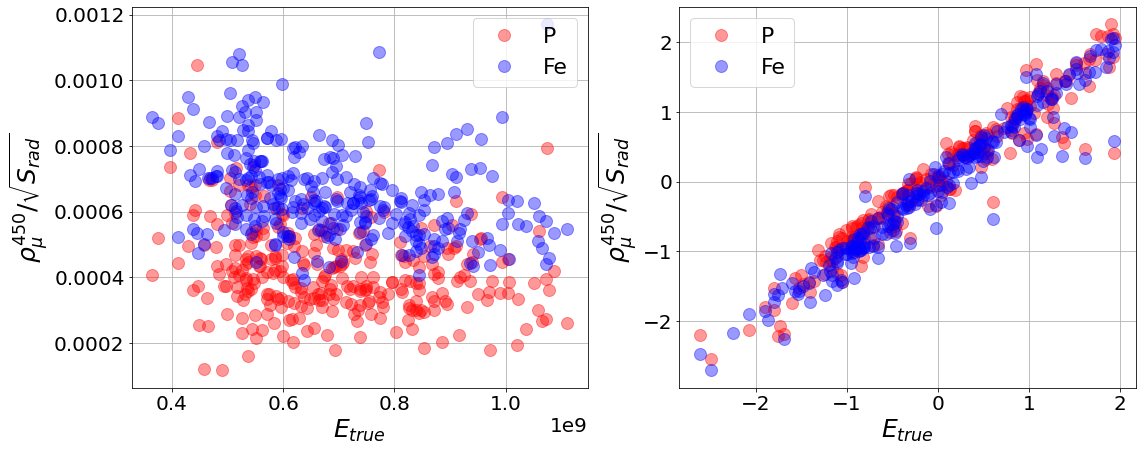

In [237]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(np.sqrt(dp["MC energy"]), dp['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.sqrt(df["MC energy"]), df['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==-1, 0], XX[yy==-1, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [238]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=100, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [239]:
model_Log_5 = rnd_search_cv.best_estimator_
model_Log_5

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=39.577418772485736, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [240]:
print(accuracy(X_train, y_train, model_Log_5))
print(crossAccuracy(X_train, y_train, model_Log_5))

0.8729508196721312
Accuracy:  0.873001700680272 0.04578513124847666
presicion:  0.8626062536497319 0.04902408240644852
recall:  0.8893333333333333 0.04539456648836585
F1_score:  0.8753935397461333 0.04404917475070787
None


In [241]:
auc_cv(X_train, y_train, model_Log_5)

0.9385416666666668 0.04340876625353827


In [242]:
print(crossAccuracy(X_test, y_test, model_Log_5))

Accuracy:  0.8301282051282051 0.12476967603491111
presicion:  0.8304761904761906 0.12939682150256238
recall:  0.8523809523809522 0.15714285714285714
F1_score:  0.8325029872088695 0.12488188985889467
None


In [243]:
auc_cv(X_test, y_test, model_Log_5)

0.8912698412698413 0.0908062761784605


In [244]:
mconfusion(X_train, y_train, model_Log_5)

Matriz de confusión, 

[[209  35]
 [ 27 217]]
precisión:  0.8611111111111112
exhaustividad:  0.889344262295082


In [245]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_5.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.89      0.85      0.87       244
           1       0.86      0.89      0.88       244

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488



In [246]:
ypred = cross_val_predict(model_Log_5, X_train, y_train, cv=5, method="decision_function")

In [247]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

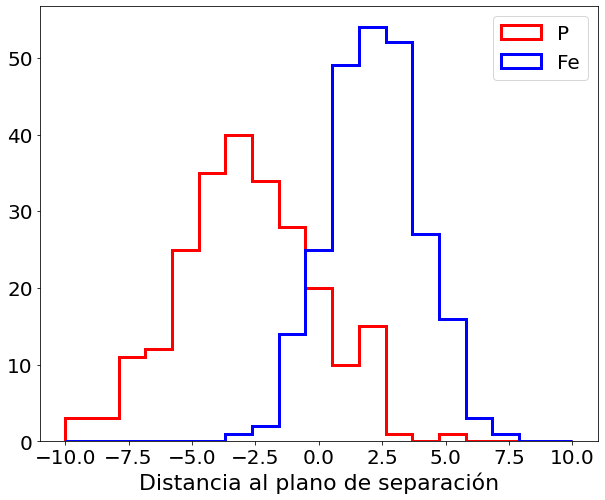

In [248]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [249]:
boostMF(c1_pred, c2_pred)

('1.50', '0.08')

In [883]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 19)

In [884]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [443]:
model_Log_6 = rnd_search_cv.best_estimator_
model_Log_6

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.1177911254719897, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [444]:
print(accuracy(X_poly2, y_train, model_Log_6))
print(crossAccuracy(X_poly2, y_train, model_Log_6))

0.8770491803278688
Accuracy:  0.8689200680272109 0.054394541047094104
presicion:  0.8554062199669396 0.05225315848563704
recall:  0.8896666666666666 0.0628127729402583
F1_score:  0.8716360889509467 0.053354613745262736
None


In [445]:
mconfusion(X_poly2, y_train, model_Log_6)

Matriz de confusión, 

[[207  37]
 [ 27 217]]
precisión:  0.8543307086614174
exhaustividad:  0.889344262295082


In [446]:
print(classification_report(y_train, model_Log_6.predict(X_poly2)))

              precision    recall  f1-score   support

          -1       0.90      0.85      0.87       244
           1       0.86      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [685]:
ypred = cross_val_predict(model_Log_6, X_poly2, y_train, cv=5, method="decision_function")

In [686]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

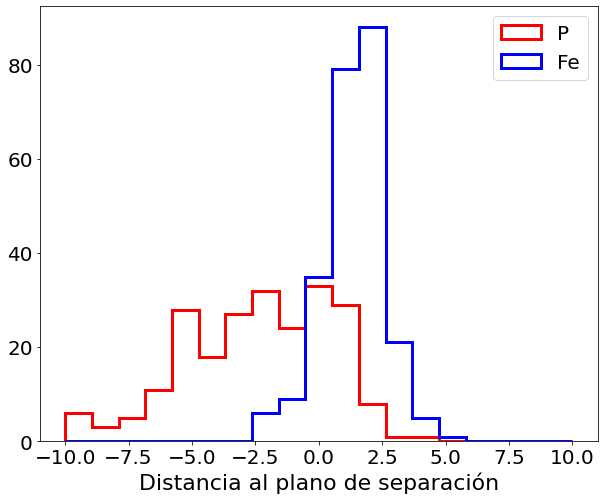

In [687]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [688]:
boostMF(c1_pred, c2_pred)

('0.86', '0.12')

## SVM

In [921]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [922]:
model_svm_5 = rnd_search_cv.best_estimator_
model_svm_5

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=72.60383354696403, break_ties=False, cache_size=200,
                     class_weight=None, coef0=30.646885884107178,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.000739100753156253, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [923]:
print(accuracy(X_train, y_train, model_svm_5))
print(crossAccuracy(X_train, y_train, model_svm_5))

0.875
Accuracy:  0.8770833333333332 0.043207174699450276
presicion:  0.8554074058819185 0.0460593186204152
recall:  0.9098333333333333 0.048174739807865664
F1_score:  0.8811995353906419 0.04164492955118541
None


In [924]:
print(crossAccuracy(X_test, y_test, model_svm_5))

Accuracy:  0.8384615384615385 0.10990552394947582
presicion:  0.837857142857143 0.12729725777382125
recall:  0.869047619047619 0.12428936320131609
F1_score:  0.8451137098195922 0.09868826592509697
None


In [925]:
mconfusion(X_train, y_train, model_svm_5)

Matriz de confusión, 

[[206  38]
 [ 22 222]]
precisión:  0.8538461538461538
exhaustividad:  0.9098360655737705


In [926]:
print(classification_report(y_train, model_svm_5.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.90      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [927]:
ypred = cross_val_predict(model_svm_5, X_train, y_train, cv=5, method="decision_function")

In [928]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

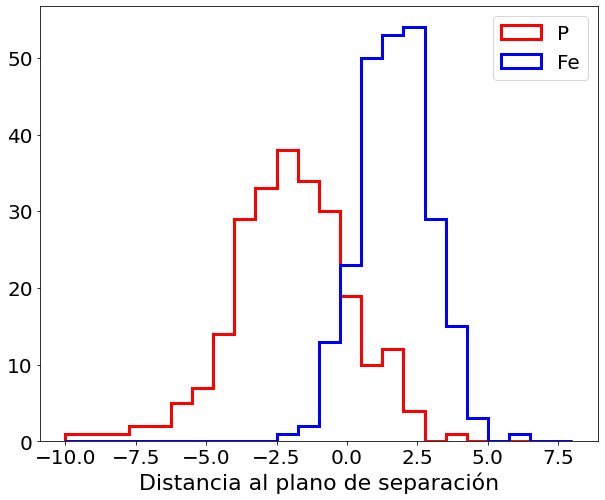

In [930]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 8, 25)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [931]:
boostMF(c1_pred, c2_pred)

('1.50', '0.08')

In [469]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=10, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,


In [470]:
model_svm_5p = rnd_search_cv.best_estimator_
model_svm_5p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=278.7005484082623, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [471]:
print(accuracy(X_train, y_train, model_svm_5p))
print(crossAccuracy(X_train, y_train, model_svm_5p))

0.875
Accuracy:  0.8649234693877551 0.044783165485409906
presicion:  0.8343956282460177 0.04780834175465585
recall:  0.9138333333333334 0.06543890280253788
F1_score:  0.8708996110802074 0.045309491797671436
None


In [472]:
mconfusion(X_train, y_train, model_svm_5p)

Matriz de confusión, 

[[199  45]
 [ 21 223]]
precisión:  0.832089552238806
exhaustividad:  0.9139344262295082


In [473]:
print(classification_report(y_train, model_svm_5p.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.92      0.82      0.87       244
           1       0.84      0.93      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [474]:
ypred = cross_val_predict(model_svm_5p, X_train, y_train, cv=5, method="decision_function")

In [475]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

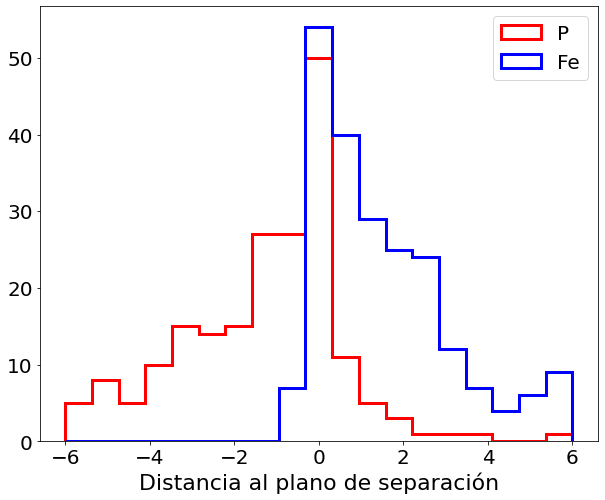

In [476]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [477]:
boostMF(c1_pred, c2_pred)

('0.62', '0.09')

In [214]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [215]:
model_svm_6 = rnd_search_cv.best_estimator_
model_svm_6

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=34.13962784939366, break_ties=False, cache_size=200,
                     class_weight=None, coef0=92.03575824872748,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.022326082731438105, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [216]:
print(accuracy(X_train, y_train, model_svm_6))
print(crossAccuracy(X_train, y_train, model_svm_6))

0.8770491803278688
Accuracy:  0.8791241496598639 0.0436606602544277
presicion:  0.856086459517494 0.04965691175329272
recall:  0.914 0.038630730427126704
F1_score:  0.8837218824636773 0.041044665955954525
None


In [217]:
auc_cv(X_train, y_train, model_svm_6)

0.9410972222222223 0.039394552268769215


In [218]:
print(crossAccuracy(X_test, y_test, model_svm_6))

Accuracy:  0.8384615384615384 0.10990552394947582
presicion:  0.8235714285714286 0.11579582664926986
recall:  0.8857142857142858 0.12945025922922082
F1_score:  0.8465123112181935 0.09967916434697428
None


In [219]:
auc_cv(X_test, y_test, model_svm_6)

0.9123015873015874 0.08330403869070159


In [220]:
mconfusion(X_train, y_train, model_svm_6)

Matriz de confusión, 

[[206  38]
 [ 21 223]]
precisión:  0.8544061302681992
exhaustividad:  0.9139344262295082


In [221]:
print(classification_report(y_train, model_svm_6.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.90      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [222]:
ypred = cross_val_predict(model_svm_6, X_train, y_train, cv=5, method="decision_function")

In [223]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

Saving figure obs_1_hist_best


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


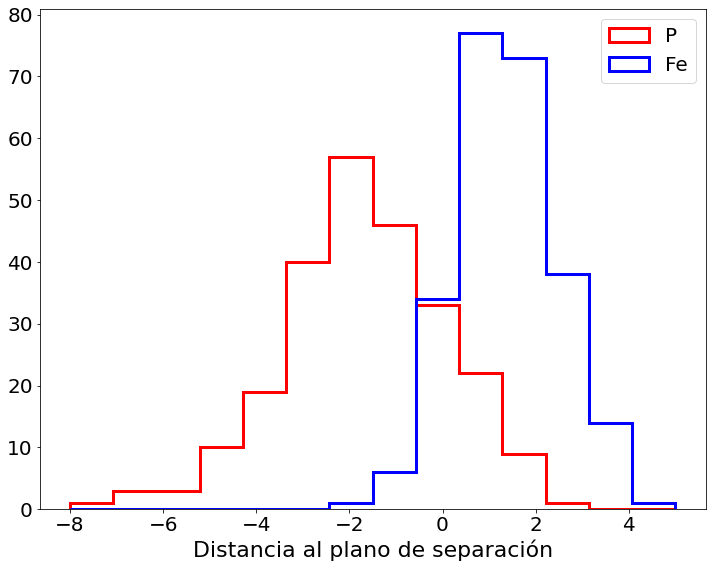

In [224]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-8, 5, 15)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
#save_fig("obs_1_hist_best")
plt.show()

In [226]:
boostMF(c1_pred, c2_pred)

('1.52', '0.08')

## Sumando el angulo cenital

In [491]:
#Features

df_train_2 = df_train[["MC energy", "MC zenith", "rootSrad", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "MC zenith", "rootSrad", "N_mu_ref", "target"]]

In [492]:
print(df_train_2.shape, df_test_.shape)

(488, 5) (122, 63)


In [493]:
df_train_2.head()

,MC energy,MC zenith,rootSrad,N_mu_ref,target
246,3.824250e+17,50.0277,1186.642322,0.850606,1
76,7.590210e+17,50.6696,2251.384019,1.114180,1
171,6.116010e+17,40.6307,1867.359098,1.146870,1
191,3.842740e+17,53.6568,1327.143549,0.612265,1
75,9.452550e+17,49.0955,2809.946619,1.232080,1


In [494]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC zenith    0.016190
MC energy   -0.005095
rootSrad    -0.057361
Name: target, dtype: float64

In [495]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 4) (488,) (488, 4) (122,)


In [496]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [497]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [498]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 4) (122, 4) (488,) (122,)


In [499]:
X_train.head()

,MC energy,MC zenith,rootSrad,N_mu_ref
0,-0.324464,0.607596,-0.190732,0.462230
1,1.092195,0.757615,1.100626,1.066291
2,0.651643,-1.051059,0.722051,1.133262
3,-0.314309,1.527753,0.033892,-0.224563
4,1.534527,0.398978,1.550809,1.301173


In [500]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

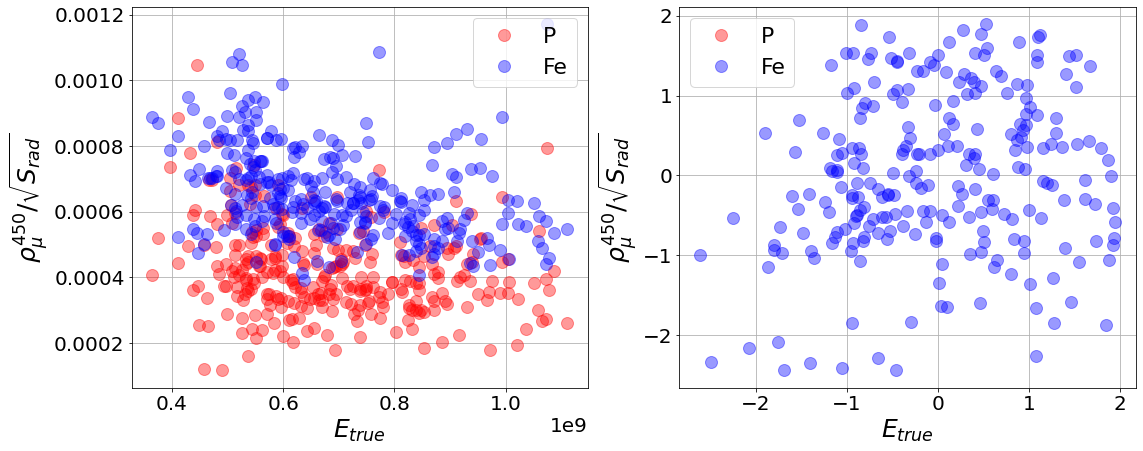

In [501]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(np.sqrt(dp["MC energy"]), dp['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.sqrt(df["MC energy"]), df['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==0, 0], XX[yy==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [502]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=100, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [503]:
model_Log_7 = rnd_search_cv.best_estimator_
model_Log_7

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.6795048582640127, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [504]:
print(accuracy(X_train, y_train, model_Log_7))
print(crossAccuracy(X_train, y_train, model_Log_7))

0.8729508196721312
Accuracy:  0.8730017006802722 0.041989090739732886
presicion:  0.8574065934065933 0.05003375814325158
recall:  0.8975000000000002 0.033451872560109064
F1_score:  0.8766288477655213 0.039211810652597975
None


In [505]:
mconfusion(X_train, y_train, model_Log_7)

Matriz de confusión, 

[[207  37]
 [ 25 219]]
precisión:  0.85546875
exhaustividad:  0.8975409836065574


In [506]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_7.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.90      0.84      0.87       244
           1       0.85      0.90      0.88       244

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488



In [507]:
ypred = cross_val_predict(model_Log_7, X_train, y_train, cv=5, method="decision_function")

In [508]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

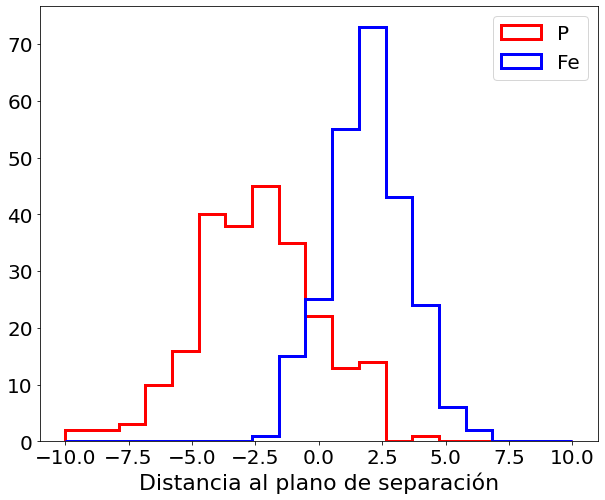

In [509]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [510]:
boostMF(c1_pred, c2_pred)

('1.50', '0.08')

In [511]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 34)

In [512]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [513]:
model_Log_8 = rnd_search_cv.best_estimator_
model_Log_8

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.8116295644189262, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [514]:
print(accuracy(X_poly2, y_train, model_Log_8))
print(crossAccuracy(X_poly2, y_train, model_Log_8))

0.8790983606557377
Accuracy:  0.8646683673469389 0.0630835620281766
presicion:  0.8479985754985755 0.05777389997140964
recall:  0.8891666666666668 0.0812754233729019
F1_score:  0.8671419980667642 0.06555148902146334
None


In [515]:
mconfusion(X_poly2, y_train, model_Log_8)

Matriz de confusión, 

[[205  39]
 [ 27 217]]
precisión:  0.84765625
exhaustividad:  0.889344262295082


In [516]:
print(classification_report(y_train, model_Log_8.predict(X_poly2)))

              precision    recall  f1-score   support

          -1       0.90      0.85      0.88       244
           1       0.86      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [517]:
ypred = cross_val_predict(model_Log_8, X_poly2, y_train, cv=5, method="decision_function")

In [518]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

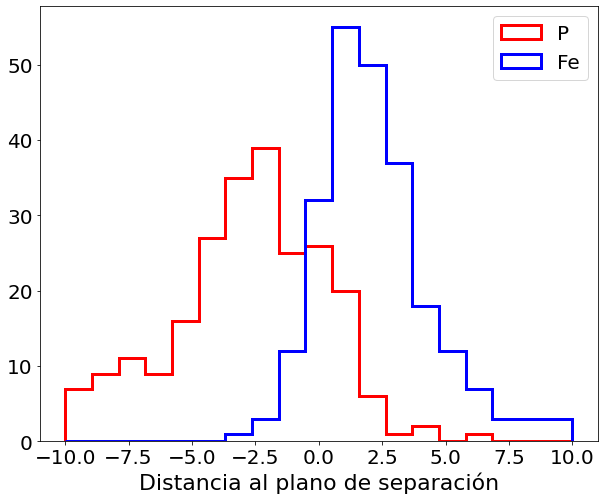

In [519]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [520]:
boostMF(c1_pred, c2_pred)

('1.15', '0.11')

## SVM

In [521]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(0.0001, 10), "svm_clf__C": uniform(1, 1000), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [522]:
model_svm_7 = rnd_search_cv.best_estimator_
model_svm_7

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=36.790004148168684, break_ties=False, cache_size=200,
                     class_weight=None, coef0=48.204921526992585,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.015949100980146153, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [523]:
print(accuracy(X_train, y_train, model_svm_7))
print(crossAccuracy(X_train, y_train, model_svm_7))

0.875
Accuracy:  0.8770833333333332 0.04223223081884425
presicion:  0.8528105132415478 0.04799543473690338
recall:  0.9136666666666666 0.03929093760369911
F1_score:  0.8817800107948355 0.03985959019637461
None


In [524]:
mconfusion(X_train, y_train, model_svm_7)

Matriz de confusión, 

[[205  39]
 [ 21 223]]
precisión:  0.851145038167939
exhaustividad:  0.9139344262295082


In [525]:
print(classification_report(y_train, model_svm_7.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.91      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [526]:
ypred = cross_val_predict(model_svm_7, X_train, y_train, cv=5, method="decision_function")

In [527]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

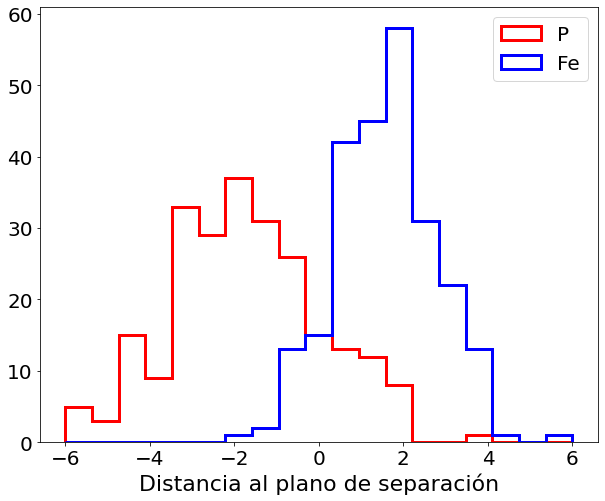

In [528]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [529]:
boostMF(c1_pred, c2_pred)

('1.50', '0.09')

In [530]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=10, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,


In [531]:
model_svm_7p = rnd_search_cv.best_estimator_
model_svm_7p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=29.86323430412885, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [532]:
print(accuracy(X_train, y_train, model_svm_7p))
print(crossAccuracy(X_train, y_train, model_svm_7p))

0.8729508196721312
Accuracy:  0.8709183673469388 0.038034165848113
presicion:  0.8419547948858295 0.035525449635807775
recall:  0.9138333333333334 0.04660144251463086
F1_score:  0.8761025215117492 0.03719406929616918
None


In [533]:
mconfusion(X_train, y_train, model_svm_7p)

Matriz de confusión, 

[[202  42]
 [ 21 223]]
precisión:  0.8415094339622642
exhaustividad:  0.9139344262295082


In [534]:
print(classification_report(y_train, model_svm_7p.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.91      0.83      0.87       244
           1       0.84      0.92      0.88       244

    accuracy                           0.87       488
   macro avg       0.88      0.87      0.87       488
weighted avg       0.88      0.87      0.87       488



In [535]:
ypred = cross_val_predict(model_svm_7p, X_train, y_train, cv=5, method="decision_function")

In [536]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

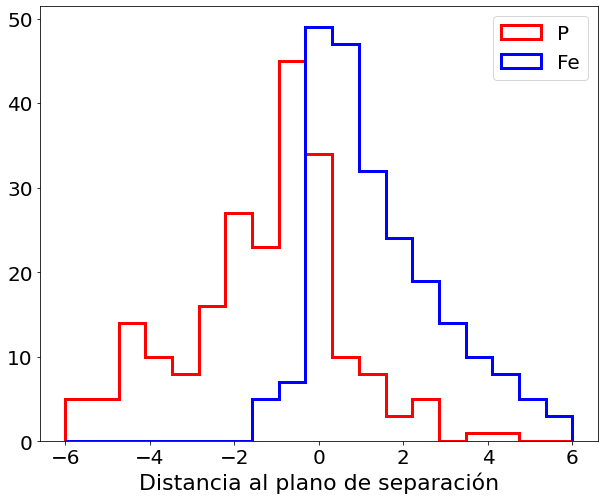

In [537]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [538]:
boostMF(c1_pred, c2_pred)

('0.81', '0.10')

In [539]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(0.0001, 10), "svm_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,


In [540]:
model_svm_8 = rnd_search_cv.best_estimator_
model_svm_8

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=145.49183046212156, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.0015191876999077504, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [541]:
print(accuracy(X_train, y_train, model_svm_8))
print(crossAccuracy(X_train, y_train, model_svm_8))

0.875
Accuracy:  0.8749574829931973 0.04289477160448547
presicion:  0.8467130647130647 0.0462887040767579
recall:  0.9176666666666667 0.04169465726498352
F1_score:  0.8803489987101847 0.04008614803151794
None


In [542]:
mconfusion(X_train, y_train, model_svm_8)

Matriz de confusión, 

[[203  41]
 [ 20 224]]
precisión:  0.8452830188679246
exhaustividad:  0.9180327868852459


In [543]:
print(classification_report(y_train, model_svm_8.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.91      0.83      0.87       244
           1       0.85      0.92      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [544]:
ypred = cross_val_predict(model_svm_8, X_train, y_train, cv=5, method="decision_function")

In [546]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

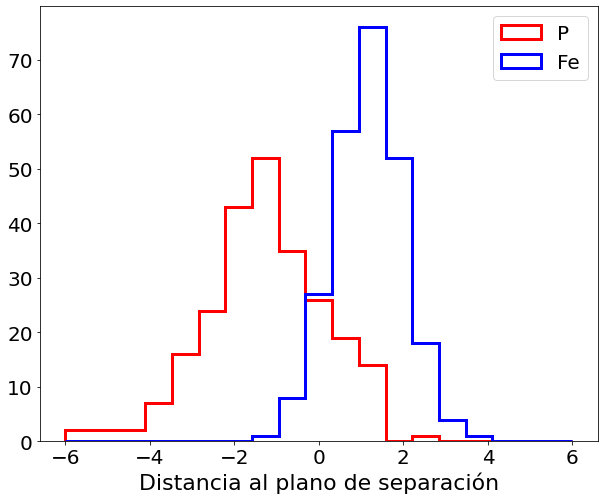

In [547]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [548]:
boostMF(c1_pred, c2_pred)

('1.51', '0.09')

In [549]:
"Stations with Pulse"

'Stations with Pulse'

## Incluyendo estaciones de Radio

In [550]:
#Features

df_train_2 = df_train[["MC energy", "Stations with Pulse", "MC zenith", "rootSrad", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "Stations with Pulse", "MC zenith", "rootSrad", "N_mu_ref", "target"]]

In [551]:
print(df_train_2.shape, df_test_.shape)

(488, 6) (122, 63)


In [552]:
df_train_2.head()

,MC energy,Stations with Pulse,MC zenith,rootSrad,N_mu_ref,target
246,3.824250e+17,5,50.0277,1186.642322,0.850606,1
76,7.590210e+17,6,50.6696,2251.384019,1.114180,1
171,6.116010e+17,7,40.6307,1867.359098,1.146870,1
191,3.842740e+17,31,53.6568,1327.143549,0.612265,1
75,9.452550e+17,9,49.0955,2809.946619,1.232080,1


In [553]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target                 1.000000
N_mu_ref               0.384449
Stations with Pulse    0.031046
MC zenith              0.016190
MC energy             -0.005095
rootSrad              -0.057361
Name: target, dtype: float64

In [554]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 5) (488,) (488, 5) (122,)


In [555]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [556]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [557]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 5) (122, 5) (488,) (122,)


In [558]:
X_train.head()

,MC energy,Stations with Pulse,MC zenith,rootSrad,N_mu_ref
0,-0.324464,-1.310774,0.607596,-0.190732,0.462230
1,1.092195,-0.712103,0.757615,1.100626,1.066291
2,0.651643,-0.284582,-1.051059,0.722051,1.133262
3,-0.314309,1.699532,1.527753,0.033892,-0.224563
4,1.534527,0.285287,0.398978,1.550809,1.301173


In [559]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

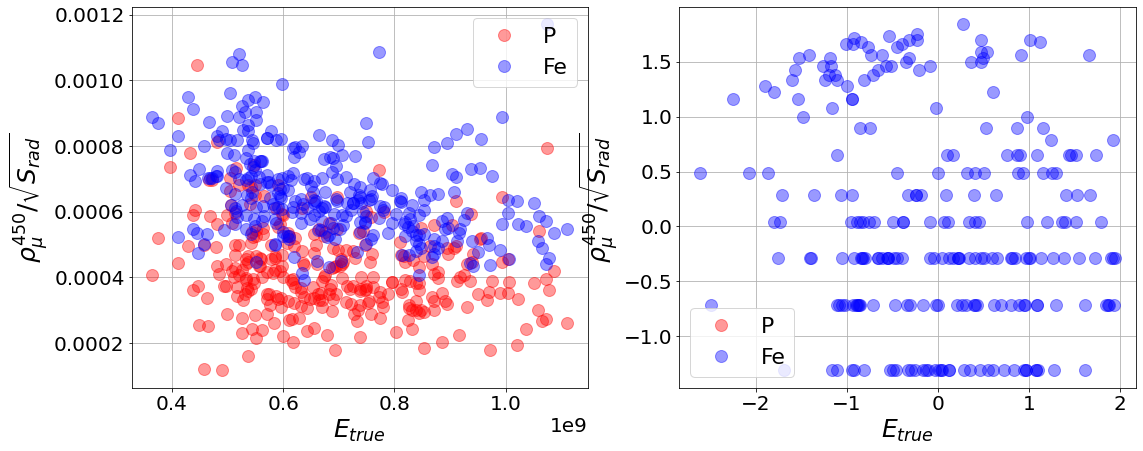

In [560]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(np.sqrt(dp["MC energy"]), dp['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.sqrt(df["MC energy"]), df['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==0, 0], XX[yy==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [561]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=100, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [562]:
model_Log_9 = rnd_search_cv.best_estimator_
model_Log_9

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=14.542610419259683, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [563]:
print(accuracy(X_train, y_train, model_Log_9))
print(crossAccuracy(X_train, y_train, model_Log_9))

0.8729508196721312
Accuracy:  0.8709608843537413 0.045076549861593054
presicion:  0.8566129426129425 0.051213701311026816
recall:  0.8935000000000001 0.03745701239791794
F1_score:  0.8743792106102237 0.04233274096763008
None


In [564]:
mconfusion(X_train, y_train, model_Log_9)

Matriz de confusión, 

[[207  37]
 [ 26 218]]
precisión:  0.8549019607843137
exhaustividad:  0.8934426229508197


In [565]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_9.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.89      0.85      0.87       244
           1       0.86      0.90      0.88       244

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488



In [566]:
ypred = cross_val_predict(model_Log_9, X_train, y_train, cv=5, method="decision_function")

In [567]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

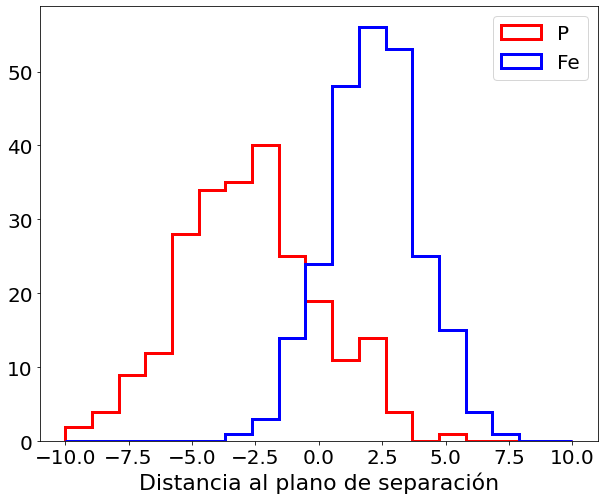

In [568]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [569]:
boostMF(c1_pred, c2_pred)

('1.48', '0.09')

In [570]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 55)

In [571]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [572]:
model_Log_10 = rnd_search_cv.best_estimator_
model_Log_10

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.4106404415378915, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [573]:
print(accuracy(X_poly2, y_train, model_Log_10))
print(crossAccuracy(X_poly2, y_train, model_Log_10))

0.9016393442622951
Accuracy:  0.8667091836734693 0.060440957216111924
presicion:  0.8550811929200235 0.05890481855899002
recall:  0.8844999999999998 0.08331683169950982
F1_score:  0.868055220170052 0.06369407229042114
None


In [574]:
mconfusion(X_poly2, y_train, model_Log_10)

Matriz de confusión, 

[[207  37]
 [ 28 216]]
precisión:  0.8537549407114624
exhaustividad:  0.8852459016393442


In [575]:
print(classification_report(y_train, model_Log_10.predict(X_poly2)))

              precision    recall  f1-score   support

          -1       0.93      0.87      0.90       244
           1       0.88      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [576]:
ypred = cross_val_predict(model_Log_10, X_poly2, y_train, cv=5, method="decision_function")

In [577]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

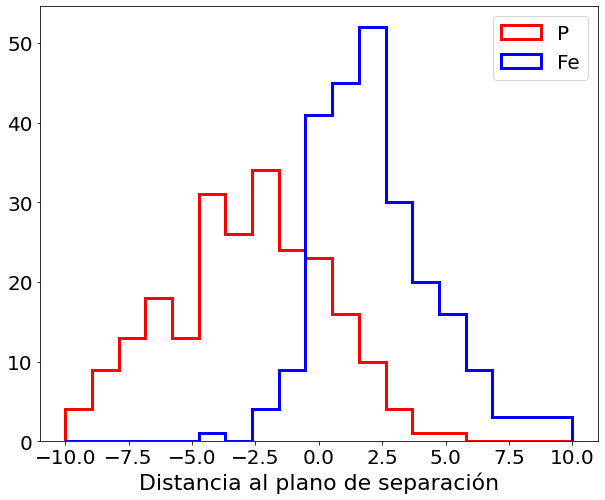

In [578]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [579]:
boostMF(c1_pred, c2_pred)

('1.11', '0.11')

## SVM

In [580]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(0.0001, 10), "svm_clf__C": uniform(1, 1000), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [581]:
model_svm_9 = rnd_search_cv.best_estimator_
model_svm_9

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=760.5687891646901, break_ties=False, cache_size=200,
                     class_weight=None, coef0=62.70890124148062,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.0011039660800519762, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [582]:
print(accuracy(X_train, y_train, model_svm_9))
print(crossAccuracy(X_train, y_train, model_svm_9))

0.8709016393442623
Accuracy:  0.8709183673469388 0.04532368763296579
presicion:  0.8479768009768008 0.04837891394635897
recall:  0.9055 0.04592899108648287
F1_score:  0.8754216699742304 0.04382086500631616
None


In [583]:
mconfusion(X_train, y_train, model_svm_9)

Matriz de confusión, 

[[204  40]
 [ 23 221]]
precisión:  0.8467432950191571
exhaustividad:  0.9057377049180327


In [584]:
print(classification_report(y_train, model_svm_9.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.90      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488



In [585]:
ypred = cross_val_predict(model_svm_9, X_train, y_train, cv=5, method="decision_function")

In [586]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

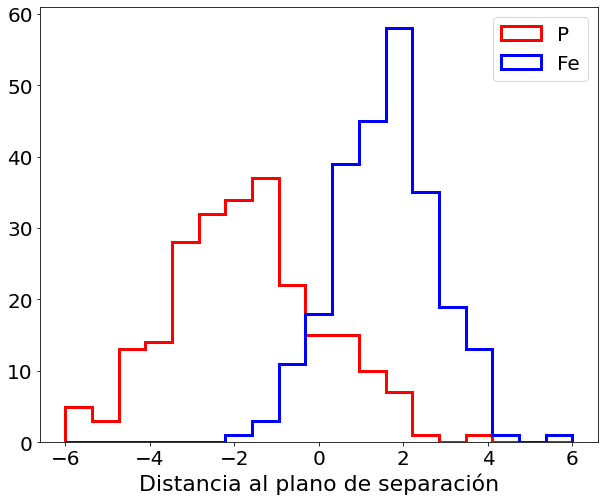

In [587]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [588]:
boostMF(c1_pred, c2_pred)

('1.49', '0.09')

In [589]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [590]:
model_svm_9p = rnd_search_cv.best_estimator_
model_svm_9p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=45.777008238409366, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [591]:
print(accuracy(X_train, y_train, model_svm_9p))
print(crossAccuracy(X_train, y_train, model_svm_9p))

0.8770491803278688
Accuracy:  0.8708758503401361 0.05770234546409651
presicion:  0.8521587020897365 0.04842856213423518
recall:  0.8975000000000002 0.08659371930008677
F1_score:  0.8728554857840571 0.061261714763307884
None


In [592]:
mconfusion(X_train, y_train, model_svm_9p)

Matriz de confusión, 

[[206  38]
 [ 25 219]]
precisión:  0.8521400778210116
exhaustividad:  0.8975409836065574


In [593]:
print(classification_report(y_train, model_svm_9p.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.90      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [594]:
ypred = cross_val_predict(model_svm_9p, X_train, y_train, cv=5, method="decision_function")

In [595]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

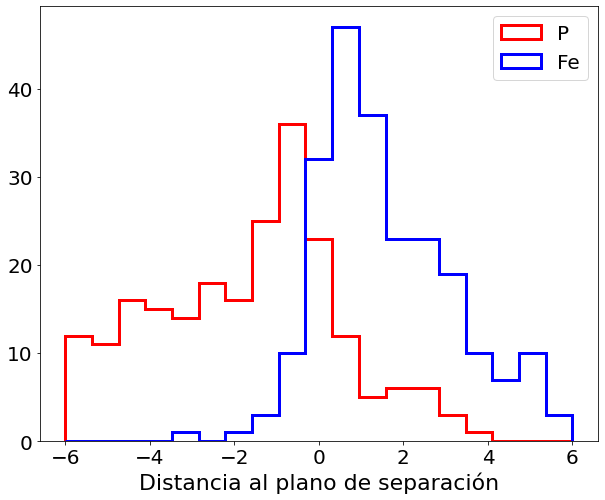

In [596]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [597]:
boostMF(c1_pred, c2_pred)

('0.91', '0.09')

In [598]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(0.0001, 10), "svm_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=500, n_jobs=-1,


In [599]:
model_svm_10 = rnd_search_cv.best_estimator_
model_svm_10

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=71.02291077905998, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.002823912214328323, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [600]:
print(accuracy(X_train, y_train, model_svm_10))
print(crossAccuracy(X_train, y_train, model_svm_10))

0.875
Accuracy:  0.8770408163265306 0.04802306740523774
presicion:  0.8475586080586079 0.05267842989889819
recall:  0.9216666666666666 0.047128665492575855
F1_score:  0.88254079298958 0.04530798252618203
None


In [601]:
mconfusion(X_train, y_train, model_svm_10)

Matriz de confusión, 

[[203  41]
 [ 19 225]]
precisión:  0.8458646616541353
exhaustividad:  0.9221311475409836


In [602]:
print(classification_report(y_train, model_svm_10.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.91      0.83      0.87       244
           1       0.85      0.92      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [603]:
ypred = cross_val_predict(model_svm_10, X_train, y_train, cv=5, method="decision_function")

In [604]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==-1.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

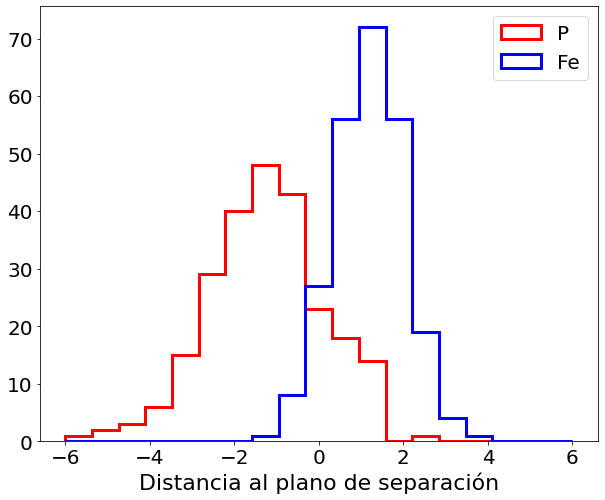

In [605]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [606]:
boostMF(c1_pred, c2_pred)

('1.50', '0.08')

In [607]:
"Stations with Pulse"

'Stations with Pulse'